In [ ]:
# This script simulates a simple harmonic oscillator with a constrained mass and spring system.
import numpy as np
import matplotlib.pyplot as plt

# Define the values
M_constrained = np.array([[1000]])  # Mass (kg)
K_constrained = np.array([[1e11]])  # Spring constant (N/m)
f_constrained = np.array([[9810]])  # Force (N)


dt = 3.14e-6               # Time step = T/200
total_time = 0.01          # Total simulation time

# Calculate number of steps
n_steps = int(total_time / dt)+1

magnitudes = ((1.0, 2.0, 3.0),)

In [1]:
# To perform test on the 2x2 system with constrained DOF (Spring-Mass system)
# This code is a simplified version of the original code provided in the prompt.
import numpy as np
import matplotlib.pyplot as plt

# Define the values for a 2x2 system
M_constrained = np.array([[1000, 0], [0, 1000]])  # Mass matrix (kg)
K_constrained = np.array([[1e11, 0], [0, 1e11]])  # Stiffness matrix (N/m)
f_constrained = np.array([[9810], [9810]])       # Force vector (N)

# Time step and total simulation time
dt = 3.14e-6               # Time step = T/200
total_time = 0.01          # Total simulation time

magnitudes = ((1.0, 2.0, 3.0),)

n_dof = M_constrained.shape[0]  # Number of degrees of freedom
x0 = np.zeros((n_dof)) # Displacement (m) as a 1x1 matrix

In [20]:
import numpy as np
import os
import glob
from pathlib import Path
from tabulate import tabulate


def process_displacement_vector(displacement_matrix):
    """Process displacement matrix for 2D analysis (remove z-component)."""
    flattened = displacement_matrix.flatten()
    displacement_2d = flattened[np.where(np.arange(len(flattened)) % 3 != 2)]
    return displacement_2d

def analyze_matrix(matrix, name, magnitude):
    """Analyze a matrix and return results in a tabular format."""
    nonzeros = np.count_nonzero(matrix)
    density = nonzeros / matrix.size
    is_symmetric = np.allclose(matrix, matrix.T, rtol=1e-8, atol=1e-8)
    max_asymmetry = np.max(np.abs(matrix - matrix.T)) if is_symmetric else 0.0

    # Eigenvalue analysis
    try:
        eigvals = np.linalg.eigvals(matrix)
        min_eigval = np.min(np.real(eigvals))
        max_eigval = np.max(np.real(eigvals))
        is_spd_eigen = True if min_eigval > 0 else False
    except np.linalg.LinAlgError:
        min_eigval = max_eigval = np.nan
        is_spd_eigen = False

    # Cholesky decomposition for SPD check
    try:
        np.linalg.cholesky(matrix)
        is_spd_cholesky = True
    except np.linalg.LinAlgError:
        is_spd_cholesky = False

    # Prepare table row
    return [
        magnitude,
        matrix.shape,
        matrix.dtype,
        f"{matrix.nbytes / 1024:.2f} KB",
        nonzeros,
        f"{density:.2%}",
        matrix.size - nonzeros,
        is_symmetric,
        f"{max_asymmetry:.2e}",
        f"{np.min(matrix):.2e}",
        f"{np.max(matrix):.2e}",
        f"{np.mean(matrix):.2e}",
        f"{np.std(matrix):.2e}",
        f"{min_eigval:.2e}",
        f"{max_eigval:.2e}",
        is_spd_eigen,
        is_spd_cholesky,
    ]

def analyze_vector(vector, name, magnitude):
    """Analyze a vector and return results in a tabular format."""
    nonzeros = np.count_nonzero(vector)
    density = nonzeros / vector.size
    return [
        magnitude,
        vector.shape,
        vector.dtype,
        f"{vector.nbytes / 1024:.2f} KB",
        nonzeros,
        f"{density:.2%}",
        vector.size - nonzeros,
        "-", "-",  # Symmetry checks (N/A for vectors)
        f"{np.min(vector):.2e}",
        f"{np.max(vector):.2e}",
        f"{np.mean(vector):.2e}",
        f"{np.std(vector):.2e}",
        "-", "-",  # Eigenvalue analysis (N/A for vectors)
        "-", "-",  # Symmetry checks (N/A for vectors)
    ]

def extract_magnitude(filename):
    """Extract the magnitude from the filename."""
    start = filename.find('[')
    end = filename.find(']')
    if start == -1 or end == -1:
        return None
    magnitude_str = filename[start + 1:end]
    return tuple(map(float, magnitude_str.split(',')))

def load_and_analyze_components(folder, component_name, analysis_function):
    """Load and analyze components (matrices or vectors) from a folder."""
    files = sorted(glob.glob(os.path.join(folder, "*.npy")))
    table_data = []
    magnitudes = []

    if not files:
        print(f"No files found in {component_name} folder.")
        return None, None

    for file in files:
        component = np.load(file)
        magnitude = extract_magnitude(os.path.basename(file))
        magnitudes.append(magnitude)
        table_data.append(analysis_function(component, component_name, magnitude))

    headers = [
        "Magnitude", "Shape", "Data Type", "Memory Size", "Non-Zero Elements", "Density",
        "Zero Elements", "Symmetry Check", "Max Asymmetry", "Min Value", "Max Value",
        "Mean Value", "Std Dev", "Min Eig Value", "Max Eig Value", "SPD (Eigen)", "Symmetric PD"
    ]
    print(f"\nDetailed Analysis of {component_name}:")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    return files, magnitudes

def load_and_analyze_displacement_vectors(folder):
    """Load and analyze displacement vectors, including processed data."""
    files = sorted(glob.glob(os.path.join(folder, "*.npy")))
    original_table_data = []
    processed_table_data = []
    magnitudes = []

    if not files:
        print("No files found in Displacement Vector folder.")
        return None, None

    for file in files:
        original_vector = np.load(file)
        processed_vector = process_displacement_vector(original_vector)
        magnitude = extract_magnitude(os.path.basename(file))
        magnitudes.append(magnitude)

        # Analyze both original and processed vectors
        original_table_data.append(analyze_vector(original_vector, "Original Displacement Vector", magnitude))
        processed_table_data.append(analyze_vector(processed_vector, "Processed Displacement Vector", magnitude))

    headers = [
        "Magnitude", "Shape", "Data Type", "Memory Size", "Non-Zero Elements", "Density",
        "Zero Elements", "Symmetry Check", "Max Asymmetry", "Min Value", "Max Value",
        "Mean Value", "Std Dev", "Min Eig Value", "Max Eig Value", "SPD (Eigen)", "Symmetric PD"
    ]

    # Print tables
    print("\nDetailed Analysis of Original Displacement Vectors:")
    print(tabulate(original_table_data, headers=headers, tablefmt="grid"))

    print("\nDetailed Analysis of Processed Displacement Vectors:")
    print(tabulate(processed_table_data, headers=headers, tablefmt="grid"))

    return files, magnitudes

def check_missing_files(mass_mags, stiffness_mags, disp_mags, force_mags):
    """Check for missing magnitudes across components and report."""
    all_magnitudes = set(mass_mags) & set(stiffness_mags) & set(disp_mags) & set(force_mags)
    missing = {
        "Mass Matrix": set(mass_mags) - all_magnitudes,
        "Stiffness Matrix": set(stiffness_mags) - all_magnitudes,
        "Displacement Vector": set(disp_mags) - all_magnitudes,
        "Force Vector": set(force_mags) - all_magnitudes,
    }

    print("\n=== Missing Files Report ===")
    for component, missing_mags in missing.items():
        if missing_mags:
            print(f" - Missing in {component}: {missing_mags}")
        else:
            print(f" - All magnitudes present in {component}.")

def final_compatibility_check(M, K, x, f):
    """Perform final compatibility check for dimensions."""
    print("\n" + "=" * 50)
    print("FINAL COMPATIBILITY CHECK")
    print("=" * 50)

    print(f"Mass matrix shape: {M.shape}")
    print(f"Stiffness matrix shape: {K.shape}")
    print(f"2D Displacement vector shape: {x[0].shape}")
    print(f"Force vector shape: {f[0].shape}")

    incompatible = []
    if M.shape != K.shape:
        incompatible.append("Mass and Stiffness matrices have different dimensions.")
    if M.shape[1] != x[0].shape[0]:
        incompatible.append("Matrix and displacement vector dimensions don't match.")
    if M.shape[1] != f[0].shape[0]:
        incompatible.append("Matrix and force vector dimensions don't match.")

    if incompatible:
        print("\nWARNING: Found incompatibilities:")
        for issue in incompatible:
            print(f" - {issue}")
    else:
        print("\nAll components have compatible dimensions!")
        print("\nAvailable components:")
        print(f"M: Shape {M.shape}")
        print(f"K: Shape {K.shape}")
        print(f"x_original: {len(x)} vectors")
        print(f"x: {x[0].shape} (Processed)")
        print(f"f: {len(f)} vectors")
        print("is_compatible: True")
        print("loaded_successfully: True")
        print("compatibility_checked: True")

def load_structural_matrices():
    """Load and analyze all structural matrices and vectors."""
    current_path = os.getcwd()
    kratos_results_path = os.path.join(current_path, "Kratos_Results")

    print("\n" + "=" * 50)
    print("LOADING MASS MATRIX")
    print("=" * 50)
    mass_folder = os.path.join(kratos_results_path, "mass_results")
    M_files, mass_magnitudes = load_and_analyze_components(mass_folder, "Mass Matrix", analyze_matrix)

    print("\n" + "=" * 50)
    print("LOADING STIFFNESS MATRIX")
    print("=" * 50)
    stiffness_folder = os.path.join(kratos_results_path, "stiffness_results")
    K_files, stiffness_magnitudes = load_and_analyze_components(stiffness_folder, "Stiffness Matrix", analyze_matrix)

    print("\n" + "=" * 50)
    print("LOADING DISPLACEMENT VECTOR")
    print("=" * 50)
    displacement_folder = os.path.join(kratos_results_path, "displacement_results")
    x_files, disp_magnitudes = load_and_analyze_displacement_vectors(displacement_folder)

    print("\n" + "=" * 50)
    print("LOADING FORCE VECTOR")
    print("=" * 50)
    force_folder = os.path.join(kratos_results_path, "loading_results")
    f_files, force_magnitudes = load_and_analyze_components(force_folder, "Force Vector", analyze_vector)

    # Check if all magnitudes are identical
    if (
        mass_magnitudes == stiffness_magnitudes == disp_magnitudes == force_magnitudes
    ):
        magnitudes = mass_magnitudes  # Use any of the lists as they are identical
        print("\nAll magnitudes are identical and saved under 'magnitudes'.")
    else:
        print("\nWarning: Magnitudes are not identical across components.")
        print(f"Mass Magnitudes: {mass_magnitudes}")
        print(f"Stiffness Magnitudes: {stiffness_magnitudes}")
        print(f"Displacement Magnitudes: {disp_magnitudes}")
        print(f"Force Magnitudes: {force_magnitudes}")
        magnitudes = None

    # Perform compatibility check if all components are loaded
    if M_files and K_files and x_files and f_files:
        # Load matrices
        M = np.load(M_files[0])
        K = np.load(K_files[0])

        # Load displacement and force vectors as 2D arrays (612 rows, columns = number of files)
        x_original = np.column_stack([np.load(file) for file in x_files])
        x = np.column_stack([process_displacement_vector(np.load(file)) for file in x_files])
        f = np.column_stack([np.load(file) for file in f_files])

        final_compatibility_check(M, K, x, f)
        print("\nMatrices successfully loaded and compatibility checked!")

        return M, K, x_original, x, f, magnitudes
    else:
        print("Error: One or more required components are missing.")
        return None, None, None, None, None, None


def final_compatibility_check(M, K, x, f):
    """Perform final compatibility check for dimensions."""
    print("\n" + "=" * 50)
    print("FINAL COMPATIBILITY CHECK")
    print("=" * 50)

    print(f"Mass matrix shape: {M.shape}")
    print(f"Stiffness matrix shape: {K.shape}")
    print(f"2D Displacement vector shape: {x.shape}")
    print(f"Force vector shape: {f.shape}")

    incompatible = []

    # Ensure matrix row sizes match vector row sizes
    if M.shape[0] != x.shape[0]:
        incompatible.append("Mass matrix row count and displacement vector row count don't match.")
    if M.shape[0] != f.shape[0]:
        incompatible.append("Mass matrix row count and force vector row count don't match.")
    if K.shape != M.shape:
        incompatible.append("Mass matrix and stiffness matrix dimensions don't match.")

    # Display compatibility results
    if incompatible:
        print("\nWARNING: Found incompatibilities:")
        for issue in incompatible:
            print(f" - {issue}")
    else:
        print("\nAll components have compatible dimensions!")

    # Summary of components
    print("\nAvailable components:")
    print(f"M: Shape {M.shape}")
    print(f"K: Shape {K.shape}")
    print(f"x_original: Shape {x.shape}")
    print(f"x: Shape {x.shape} (Processed)")
    print(f"f: Shape {f.shape}")
    print("is_compatible:", not incompatible)
    print("loaded_successfully: True")
    print("compatibility_checked: True")


# Run the function
M, K, x_original, x, f, magnitudes = load_structural_matrices()


LOADING MASS MATRIX

Detailed Analysis of Mass Matrix:
+-------------------------+------------+-------------+---------------+---------------------+-----------+-----------------+------------------+-----------------+-------------+-------------+--------------+-----------+-----------------+-----------------+---------------+----------------+
| Magnitude               | Shape      | Data Type   | Memory Size   |   Non-Zero Elements | Density   |   Zero Elements | Symmetry Check   |   Max Asymmetry |   Min Value |   Max Value |   Mean Value |   Std Dev |   Min Eig Value |   Max Eig Value | SPD (Eigen)   | Symmetric PD   |
+=========================+============+=============+===============+=====================+===========+=================+==================+=================+=============+=============+==============+===========+=================+=================+===============+================+
| (-66.78, 279.76, 305.9) | (612, 612) | float64     | 2926.12 KB    |                 612 |

In [21]:
# Check if matrices are already loaded
if 'M' in globals() and 'K' in globals() and 'x' in globals() and 'f' in globals():
    print("Matrices are already loaded and ready for boundary condition application.")
else:
    print("Error: Matrices are not loaded. Please run `load_structural_matrices()` first.")


Matrices are already loaded and ready for boundary condition application.


In [22]:
def apply_boundary_conditions_multiple_components_with_nodes(M, K, f, magnitudes):
    """
    Apply boundary conditions to the Mass matrix, Stiffness matrix, and Force vectors
    for multiple cases. Provides a tabulated summary of the constrained DOFs and Nodes for each file.
    """
    try:
        # Locate .mdpa file
        base_path = Path.cwd()
        mdpa_file = next(base_path.glob('*.mdpa'), None)
        if not mdpa_file:
            raise FileNotFoundError("No .mdpa file found in the current directory.")
        print(f"Using .mdpa file: {mdpa_file.name}")

        # Parse .mdpa file to identify fixed nodes
        nodes = {}
        fixed_nodes = set()
        with open(mdpa_file, 'r') as file:
            lines = file.readlines()

        reading_nodes = False
        reading_fixed = False

        for line in lines:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif "Begin SubModelPart DISPLACEMENT_fixed" in line or "Begin SubModelPart DISPLACEMENT_Fixed" in line:
                reading_fixed = True
                continue
            elif "End SubModelPart" in line:
                reading_fixed = False
                continue

            if reading_nodes:
                parts = line.split()
                if len(parts) >= 4:
                    node_id = int(parts[0])
                    x_coord, y_coord, z_coord = map(float, parts[1:4])
                    nodes[node_id] = (x_coord, y_coord, z_coord)

            if reading_fixed:
                try:
                    node_id = int(line)
                    print(f"Found fixed node: {node_id}")
                    fixed_nodes.add(node_id)
                except ValueError:
                    pass

        # Apply penalty method for boundary conditions
        penalty_factor = 1e12
        max_stiffness = np.max(np.abs(K))
        penalty = penalty_factor * max_stiffness

        print("\nApplying boundary conditions to Mass, Stiffness, and Force for multiple cases...")
        summary_data = []
        headers = ["File Index", "Magnitude", "Node Numbers", "Constrained DOFs (Applied Nodes)"]

        # Initialize constrained matrices
        M_constrained = np.copy(M)
        K_constrained = np.copy(K)
        f_constrained = np.copy(f)

        for file_index in range(f.shape[1]):  # Loop through each case
            applied_dofs = []
            applied_nodes = []
            for node_id in fixed_nodes:
                x_dof = (node_id - 1) * 2
                y_dof = x_dof + 1

                # Apply penalties to M, K, and f for this file
                M_constrained[x_dof, x_dof] = penalty
                M_constrained[y_dof, y_dof] = penalty
                K_constrained[x_dof, x_dof] = penalty
                K_constrained[y_dof, y_dof] = penalty
                f_constrained[x_dof, file_index] = 0.0
                f_constrained[y_dof, file_index] = 0.0

                applied_dofs.append(f"{x_dof} (X), {y_dof} (Y)")
                applied_nodes.append(node_id)

            # Append to summary table
            summary_data.append(
                [file_index + 1, magnitudes[file_index], ", ".join(map(str, applied_nodes)), ", ".join(applied_dofs)]
            )

        # Print summary table
        print("\nBoundary Condition Application Summary for Mass, Stiffness, and Force:")
        print(tabulate(summary_data, headers=headers, tablefmt="grid"))

        print("\nBoundary conditions applied successfully!")
        print(f"Number of constrained DOFs: {len(fixed_nodes) * 2}")

        return M_constrained, K_constrained, f_constrained, fixed_nodes

    except Exception as e:
        print(f"Error applying boundary conditions: {e}")
        return None, None, None, None


# Main Execution
try:
    # Ensure matrices and vectors are loaded
    if 'M' in globals() and 'K' in globals() and 'f' in globals() and 'magnitudes' in globals():
        print("Matrices are already loaded and ready for boundary condition application.")
    else:
        print("Error: Matrices are not loaded. Please load them using the proper function.")

    # Apply boundary conditions
    print("\nApplying boundary conditions for Mass, Stiffness, and Force across multiple cases...")
    M_constrained, K_constrained, f_constrained, fixed_nodes = apply_boundary_conditions_multiple_components_with_nodes(M, K, f, magnitudes)

    if M_constrained is not None:
        print("\nVerification of constrained system:")
        print(f"Original Mass Matrix Shape: {M.shape}")
        print(f"Constrained Mass Matrix Shape: {M_constrained.shape}")
        print(f"Original Stiffness Matrix Shape: {K.shape}")
        print(f"Constrained Stiffness Matrix Shape: {K_constrained.shape}")
        print(f"Original Force Vector Shape: {f.shape}")
        print(f"Constrained Force Vector Shape: {f_constrained.shape}")
        print(f"Number of constrained DOFs: {len(fixed_nodes) * 2}")
    else:
        print("Boundary conditions could not be applied.")
except Exception as e:
    print(f"Error during boundary condition application: {str(e)}")


Matrices are already loaded and ready for boundary condition application.

Applying boundary conditions for Mass, Stiffness, and Force across multiple cases...
Using .mdpa file: 2D_beam_udl_loading.mdpa
Found fixed node: 1
Found fixed node: 2
Found fixed node: 6
Found fixed node: 10
Found fixed node: 17
Found fixed node: 25

Applying boundary conditions to Mass, Stiffness, and Force for multiple cases...

Boundary Condition Application Summary for Mass, Stiffness, and Force:
+--------------+-------------------------+---------------------+--------------------------------------------------------------------------------------------+
|   File Index | Magnitude               | Node Numbers        | Constrained DOFs (Applied Nodes)                                                           |
+==============+=========================+=====================+============================================================================================+
|            1 | (-66.78, 279.76, 305.9) | 1, 

In [23]:
def compare_force_vectors_multiple(f_list, f_constrained_list, magnitudes):
    """
    Compare multiple sets of original and constrained force vectors.
    Display differences in a tabular format with magnitude headings.
    """
    # Ensure inputs are NumPy arrays and have correct dimensions
    if not isinstance(f_list, np.ndarray) or not isinstance(f_constrained_list, np.ndarray):
        raise ValueError("f_list and f_constrained_list must be NumPy arrays.")

    # Check the shapes of the input arrays
    if f_list.shape != f_constrained_list.shape:
        raise ValueError("f_list and f_constrained_list must have the same shape.")
    if f_list.shape[1] != len(magnitudes):
        raise ValueError("The number of magnitudes does not match the number of force vector files.")

    # Prepare summary table
    summary_data = []
    headers = ["File Index", "Magnitude", "Total DOFs", "Non-Zero DOFs (Original)", "Non-Zero DOFs (Constrained)", "Differences Found"]

    # Iterate over each file (column)
    for i, magnitude in enumerate(magnitudes):
        f = f_list[:, i]
        f_constrained = f_constrained_list[:, i]

        # Check if the force vectors are identical within a tolerance
        are_equal = np.allclose(f, f_constrained, rtol=1e-10)

        # Compute differences
        diff = np.abs(f - f_constrained)
        different_dofs = np.where(diff > 1e-10)[0]  # Identify DOFs with significant differences
        num_diff_dofs = len(different_dofs)

        # Count non-zero elements
        non_zero_original = np.count_nonzero(f)
        non_zero_constrained = np.count_nonzero(f_constrained)

        # Append results to the summary table
        summary_data.append([
            i + 1,
            magnitude,
            f.shape[0],
            non_zero_original,
            non_zero_constrained,
            num_diff_dofs,
        ])

    # Print summary table
    print("\nForce Vector Comparison Summary:")
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))

    # Detailed differences for each file
    for i, magnitude in enumerate(magnitudes):
        f = f_list[:, i]
        f_constrained = f_constrained_list[:, i]

        # Compute differences
        diff = np.abs(f - f_constrained)
        different_dofs = np.where(diff > 1e-10)[0]  # Identify DOFs with significant differences

        if len(different_dofs) > 0:
            print(f"\nDetailed Differences for File {i + 1} (Magnitude: {magnitude}):")
            headers = ["DOF", "Node", "Original Value", "Constrained Value", "Difference"]
            table_data = []

            for dof in different_dofs:
                # Determine the corresponding node and DOF (assuming 2 DOFs per node)
                node = dof // 2 + 1
                dof_label = "X" if dof % 2 == 0 else "Y"
                table_data.append([dof_label, node, f[dof], f_constrained[dof], diff[dof]])

            print(tabulate(table_data, headers=headers, tablefmt="grid"))
        else:
            print(f"\nNo significant differences found for File {i + 1} (Magnitude: {magnitude}).")

# Example usage
try:
    print("\nComparing force vectors for multiple files...")
    # Assuming `f` is a NumPy array of shape (DOFs, Files)
    # `f_constrained` is a NumPy array of shape (DOFs, Files)
    # `magnitudes` is a list of magnitudes corresponding to the force vector files
    compare_force_vectors_multiple(f, f_constrained, magnitudes)
except Exception as e:
    print(f"Error during force vector comparison: {str(e)}")



Comparing force vectors for multiple files...

Force Vector Comparison Summary:
+--------------+-------------------------+--------------+----------------------------+-------------------------------+---------------------+
|   File Index | Magnitude               |   Total DOFs |   Non-Zero DOFs (Original) |   Non-Zero DOFs (Constrained) |   Differences Found |
+==============+=========================+==============+============================+===============================+=====================+
|            1 | (-66.78, 279.76, 305.9) |          612 |                        611 |                           599 |                  12 |
+--------------+-------------------------+--------------+----------------------------+-------------------------------+---------------------+

Detailed Differences for File 1 (Magnitude: (-66.78, 279.76, 305.9)):
+-------+--------+------------------+---------------------+--------------+
| DOF   |   Node |   Original Value |   Constrained Value |   Differ

In [24]:
def check_bc_applied_to_force(f_constrained, magnitudes, threshold=1e-7):
    """
    Check whether boundary conditions (BC) have been applied to the constrained force vectors.
    Display results in a tabular format with magnitude headings.
    """
    # Convert 2D `f_constrained` to a list of vectors if necessary
    if isinstance(f_constrained, np.ndarray) and len(f_constrained.shape) == 2:
        print("Converting 2D array `f_constrained` to a list of vectors.")
        f_constrained = [f_constrained[:, i] for i in range(f_constrained.shape[1])]

    # Ensure lengths match
    if len(f_constrained) != len(magnitudes):
        print(f"Error: The number of constrained force vectors ({len(f_constrained)}) "
              f"does not match the number of magnitudes ({len(magnitudes)}).")
        return

    # Prepare table headers
    headers = ["File Index", "Magnitude", "DOF", "Node", "Direction", "Value"]
    summary_data = []

    for file_idx, (f_cons, magnitude) in enumerate(zip(f_constrained, magnitudes)):
        # Find non-zero DOFs
        non_zero_indices = np.where(abs(f_cons) > threshold)[0]
        if len(non_zero_indices) == 0:
            print(f"All DOFs are zero for Magnitude {magnitude}.")
            continue

        # Collect data for the table
        for dof in non_zero_indices:
            node = dof // 2 + 1  # Calculate node ID
            direction = "X" if dof % 2 == 0 else "Y"
            value = f_cons[dof]
            summary_data.append([file_idx + 1, magnitude, dof, node, direction, value])

    # Print the table
    if summary_data:
        print("\nBoundary Conditions Applied - Detailed Report:")
        print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    else:
        print("No non-zero entries found in the constrained force vectors.")

# Example Usage
try:
    print("\nChecking if boundary conditions are applied to constrained force vectors...")
    # Pass `f_constrained` and `magnitudes` to the function
    check_bc_applied_to_force(f_constrained, magnitudes)
except Exception as e:
    print(f"Error during boundary condition check: {str(e)}")



Checking if boundary conditions are applied to constrained force vectors...
Converting 2D array `f_constrained` to a list of vectors.
All DOFs are zero for Magnitude (-66.78, 279.76, 305.9).
No non-zero entries found in the constrained force vectors.


In [25]:
def check_bc_applied_to_force(f_constrained, magnitudes, threshold=1e-7):
    """
    Check whether boundary conditions (BC) have been applied to the constrained force vectors.
    Display results in a tabular format with magnitude headings.
    """
    # Convert 2D f_constrained to a list of vectors if necessary
    if isinstance(f_constrained, np.ndarray) and len(f_constrained.shape) == 2:
        print("Converting 2D array f_constrained to a list of vectors.")
        f_constrained = [f_constrained[:, i] for i in range(f_constrained.shape[1])]

    # Ensure lengths match
    if len(f_constrained) != len(magnitudes):
        print(f"Error: The number of constrained force vectors ({len(f_constrained)}) "
              f"does not match the number of magnitudes ({len(magnitudes)}).")
        return

    # Prepare table headers
    summary_headers = ["File Index", "Magnitude", "Non-Zero DOFs"]
    details_headers = ["File Index", "Magnitude", "DOF", "Node", "Direction", "Value"]

    summary_data = []
    details_data = []

    for file_idx, (f_cons, magnitude) in enumerate(zip(f_constrained, magnitudes)):
        # Find non-zero DOFs
        non_zero_indices = np.where(abs(f_cons) > threshold)[0]

        # Add summary information
        summary_data.append([
            file_idx + 1,
            magnitude,
            len(non_zero_indices),
        ])

        # Add details for non-zero DOFs
        for dof in non_zero_indices:
            node = dof // 2 + 1  # Calculate node ID
            direction = "X" if dof % 2 == 0 else "Y"
            details_data.append([
                file_idx + 1,
                magnitude,
                dof,
                node,
                direction,
                f_cons[dof],
            ])

    # Print the summary table
    print("\nBoundary Conditions Summary:")
    print(tabulate(summary_data, headers=summary_headers, tablefmt="grid"))

    # Print the detailed table if there are non-zero DOFs
    if details_data:
        print("\nNon-Zero DOFs Details:")
        print(tabulate(details_data, headers=details_headers, tablefmt="grid"))
    else:
        print("\nAll DOFs are zero across all cases.")

# Example Usage
try:
    print("\nChecking if boundary conditions are applied to constrained force vectors...")
    # Pass f_constrained and magnitudes to the function
    check_bc_applied_to_force(f_constrained, magnitudes)
except Exception as e:
    print(f"Error during boundary condition check: {str(e)}")



Checking if boundary conditions are applied to constrained force vectors...
Converting 2D array f_constrained to a list of vectors.

Boundary Conditions Summary:
+--------------+-------------------------+-----------------+
|   File Index | Magnitude               |   Non-Zero DOFs |
+==============+=========================+=================+
|            1 | (-66.78, 279.76, 305.9) |               0 |
+--------------+-------------------------+-----------------+

All DOFs are zero across all cases.


In [26]:
def apply_loads_to_force_vector_multiple_cases(f, f_constrained, fixed_dofs, magnitudes, mdpa_file):
    """
    Apply loads to force vectors for multiple cases using a single `.mdpa` file and magnitude values.
    Display the results in a well-structured tabular format with the specified format.
    """
    # Extract load nodes from the `.mdpa` file
    load_nodes = {'LinePressure2D_Load_1': [], 'LinePressure2D_Load_2': [], 'LinePressure2D_Load_3': []}
    current_load = None
    reading_nodes = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin SubModelPart LinePressure2D_Load_1" in line or "Begin SubModelPart PointLoad2D_Load_1" in line:
                current_load = 'LinePressure2D_Load_1'
            elif "Begin SubModelPart LinePressure2D_Load_2" in line or "Begin SubModelPart PointLoad2D_Load_2" in line:
                current_load = 'LinePressure2D_Load_2'
            elif "Begin SubModelPart LinePressure2D_Load_3" in line or "Begin SubModelPart PointLoad2D_Load_3" in line:
                current_load = 'LinePressure2D_Load_3'
            elif "End SubModelPart" in line:
                current_load = None
                reading_nodes = False
            elif current_load and "Begin SubModelPartNodes" in line:
                reading_nodes = True
            elif current_load and "End SubModelPartNodes" in line:
                reading_nodes = False
            elif reading_nodes and current_load and line:
                try:
                    node = int(line)
                    load_nodes[current_load].append(node)
                except ValueError:
                    continue

    # Prepare results for tabular output
    headers = ["File Index", "Magnitude", "Load 1 (Value, Direction)", "Nodes (DOF)", 
               "Load 2 (Value, Direction)", "Nodes (DOF)", "Load 3 (Value, Direction)", "Nodes (DOF)"]
    table_data = []

    print("\nApplying loads to constrained force vectors for multiple cases...")
    for i, magnitude in enumerate(magnitudes):
        load_1_details = []
        load_2_details = []
        load_3_details = []

        # Apply loads and collect node/DOF information
        for load_name, nodes in load_nodes.items():
            if load_name == 'LinePressure2D_Load_1':  # Use the first value of magnitude for vertical load
                value = magnitude[0]
                for node in nodes:
                    dof_y = (node - 1) * 2 + 1
                    f_constrained[dof_y, i] = value
                    load_1_details.append(f"{node} (Y-DOF {dof_y})")
            elif load_name == 'LinePressure2D_Load_2':  # Use the second value of magnitude for horizontal load
                value = magnitude[1]
                for node in nodes:
                    dof_x = (node - 1) * 2
                    f_constrained[dof_x, i] = value
                    load_2_details.append(f"{node} (X-DOF {dof_x})")
            elif load_name == 'LinePressure2D_Load_3':  # Use the third value of magnitude for horizontal load
                value = magnitude[2]
                for node in nodes:
                    dof_x = (node - 1) * 2
                    f_constrained[dof_x, i] = value
                    load_3_details.append(f"{node} (X-DOF {dof_x})")

        # Zero out forces at constrained DOFs
        for dof in fixed_dofs:
            f_constrained[dof, i] = 0.0

        # Add to the summary table
        table_data.append([
            i + 1,
            magnitude,
            f"{magnitude[0]} (Y)",
            ", ".join(load_1_details),
            f"{magnitude[1]} (X)",
            ", ".join(load_2_details),
            f"{magnitude[2]} (X)",
            ", ".join(load_3_details)
        ])

    # Display summary table
    print("\nLoad Application Summary:")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    print("\nLoads successfully applied to all cases.")
    return f_constrained

# Example Usage
try:
    print("\nApplying loads to constrained force vectors for multiple cases...")
    # Dynamic file reading
    folder_path = Path.cwd()
    mdpa_file = next(folder_path.glob("*.mdpa"), None)

    if mdpa_file:
        print(f"Using MDPA file: {mdpa_file.name}")

        # Assuming `f`, `f_constrained`, `fixed_nodes`, and `magnitudes` are already defined
        f_constrained = apply_loads_to_force_vector_multiple_cases(
            f=f,
            f_constrained=f_constrained,
            fixed_dofs=list(fixed_nodes),
            magnitudes=magnitudes,  # Magnitudes is a list of tuples (e.g., [(-213.96, -286.3, 284.39), ...])
            mdpa_file=mdpa_file
        )
    else:
        print("Error: MDPA file not found.")
except Exception as e:
    print(f"Error: {e}")



Applying loads to constrained force vectors for multiple cases...
Using MDPA file: 2D_beam_udl_loading.mdpa

Applying loads to constrained force vectors for multiple cases...

Load Application Summary:
+--------------+-------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+
|   File Index | Magnitude               | Load 1 (Value, Direction)   | Nodes (DOF)                                                                                          | Load 2 (Value, Direction)   | Nodes (DOF)                                                                                          | Load 3 (Value, Direction)   | Nodes (DOF)     

In [27]:
# import numpy as np
# from scipy import linalg
# import matplotlib.pyplot as plt

# # Define system matrices
# M = np.array([[2.0, 0.0], [0.0, 1.0]])  # Mass matrix
# K = np.array([[10.0, -2.0], [-2.0, 5.0]])  # Stiffness matrix

# # Define force vector for each time step (zero force in this case)
# total_time = 100.0
# dt = 0.02
# n_steps = int(total_time / dt) + 1
# F = np.zeros((n_steps, 2))  # Two DOFs, force applied is zero

# # Initial conditions
# initial_displacement = np.array([1.0, 0.5])

# # Define structural components dictionary
# structural_components = {
#     'M_constrained': M,
#     'K_constrained': K,
#     'f_constrained': F
# }

# # Newmark parameters
# beta = 0.25
# gamma = 0.5
# tol = 1e-6
# max_iter = 100

# # Run the solver
# results = solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt,
#                                             beta, gamma, tol, max_iter)

# # Plotting results
# time = results['time']
# displacement = results['displacement']
# velocity = results['velocity']
# acceleration = results['acceleration']

# plt.figure(figsize=(12, 6))

# # Plot Displacement for each DOF
# plt.subplot(3, 1, 1)
# plt.plot(time, displacement[:, 0], label='DOF 1')
# plt.plot(time, displacement[:, 1], label='DOF 2')
# plt.title('Displacement')
# plt.legend()

# # Plot Velocity for each DOF
# plt.subplot(3, 1, 2)
# plt.plot(time, velocity[:, 0], label='DOF 1')
# plt.plot(time, velocity[:, 1], label='DOF 2')
# plt.title('Velocity')
# plt.legend()

# # Plot Acceleration for each DOF
# plt.subplot(3, 1, 3)
# plt.plot(time, acceleration[:, 0], label='DOF 1')
# plt.plot(time, acceleration[:, 1], label='DOF 2')
# plt.title('Acceleration')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [36]:
import numpy as np
from scipy import linalg
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import time
from tabulate import tabulate

# def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
#                                      beta, gamma, tol, max_iter):
#     """
#     Solve dynamic system for a single case using Newmark-β method

#     Args:
#         structural_components (dict): Contains system matrices (M, K, F)
#         initial_displacement (np.array): Initial displacement vector for this case (1D array)
#         total_time (float): Total simulation time
#         dt (float): Time step size
#         beta (float): Newmark-β parameter
#         gamma (float): Newmark-γ parameter
#         tol (float): Convergence tolerance
#         max_iter (int): Maximum iterations per time step

#     Returns:
#         dict: Results including displacements, velocities, accelerations, etc.
#     """
#     # Get system matrices and force vector
#     M = structural_components['M_constrained']
#     K = structural_components['K_constrained']
#     F = structural_components['f_constrained']
#     n = M.shape[0]

#     # Scale matrices to improve conditioning
#     M_scale = 1.0 
#     K_scale = 1.0 
#     F_scale = 1.0 

#     M_scaled = M / M_scale
#     K_scaled = K / K_scale
#     F_scaled = F / F_scale
    
#     print("\nMatrix scaling factors:")
#     print(f"Mass matrix scale: {M_scale:.2e}")
#     print(f"Stiffness matrix scale: {K_scale:.2e}")
#     print(f"Force vector scale: {F_scale:.2e}")

#     # Setup time integration
#     n_steps = int(total_time / dt) + 1
#     t = np.linspace(0, total_time, n_steps)

#     # Initialize solution arrays
#     d = np.zeros((n_steps, n))  # Displacement
#     v = np.zeros((n_steps, n))  # Velocity
#     a = np.zeros((n_steps, n))  # Acceleration

#     # Set initial displacement for this case
#     d[0] = initial_displacement  # Correctly set the initial displacement

#     # Initial acceleration
#     a[0] = linalg.solve(M_scaled, F_scaled[0] - K_scaled @ d[0])

#     # Newmark constants (pre-calculate for efficiency)
#     c1 = 1 / (beta * dt**2)
#     c2 = gamma / (beta * dt)
#     c3 = 1 / (beta * dt)
#     c5 = (1 - 2 * beta) / (2 * beta)

#     # Effective stiffness matrix (K_tan^dyn), pre-factor for efficiency
#     K_eff = K_scaled + c1 * M_scaled
#     K_eff_factor = linalg.lu_factor(K_eff)

#     # Convergence tracking arrays
#     iterations_per_step = np.zeros(n_steps, dtype=int)
#     residuals_per_step = np.zeros(n_steps)
#     convergence_status = np.ones(n_steps, dtype=bool)

#     # Time stepping
#     for i in range(1, n_steps):
#         a_pred = a[i-1].copy()  # Initial guess for a_i
#         d_pred = d[i - 1] + dt * v[i - 1] + (dt**2) * ((1 - 2 * beta) / 2 * a[i - 1] + beta * a_pred)
#         v_pred = v[i - 1] + dt * ((1 - gamma) * a[i - 1] + gamma * a_pred)

#         # Newton-Raphson iteration
#         d[i] = d_pred.copy()  # Initial guess for displacement at i
#         v[i] = v_pred.copy()  # Initial guess for velocity at i
#         converged = False

#         for j in range(max_iter):
#             # Calculate accelerations and velocities based on x_{n+1} (Eqs. 2.17 & 2.18)
#             a_i = c1 * (d[i] - d[i - 1]) - c3 * v[i - 1] - c5 * a[i - 1]
#             v_i = c2 * (d[i] - d[i - 1]) - (gamma/beta - 1) * v[i-1] - (dt/2) * (gamma/beta - 2) * a[i - 1]

#             # Calculate the residual force (Eq 2.19):
#             R = F[i] - M @ a_i - K @ d[i]

#             residual_norm = np.linalg.norm(R)

#             # Check for Convergence
#             if residual_norm < tol:
#                 converged = True
#                 iterations_per_step[i] = j + 1
#                 residuals_per_step[i] = residual_norm
#                 a[i] = a_i
#                 v[i] = v_i
#                 break

#             # Solve for the displacement increment (delta_d)
#             try:
#                 delta_d = linalg.lu_solve(K_eff_factor, R)
#                 d[i] += delta_d
#             except np.linalg.LinAlgError:
#                 break

#         if not converged:
#             convergence_status[i] = False
#             iterations_per_step[i] = max_iter
#             residuals_per_step[i] = residual_norm
#             a[i] = a_i
#             v[i] = v_i
    
#     return {
#         'time': t,
#         'displacement': d,
#         'velocity': v,
#         'acceleration': a,
#         'iterations_per_step': iterations_per_step,
#         'residuals_per_step': residuals_per_step,
#         'convergence_status': convergence_status,
#         'scales': {'M_scale': M_scale, 'K_scale': K_scale, 'F_scale': F_scale}
#     }

# Newmark-Beta Method Implementation for MDOF Spring-Mass System with Newton-Raphson Iteration

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg


def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
                                     beta, gamma, tol, max_iter):
    """
    Solve dynamic system for a single case using Newmark-β method

    Args:
        structural_components (dict): Contains system matrices (M, K, F)
        initial_displacement (np.array): Initial displacement vector for this case (1D array)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        dict: Results including displacements, velocities, accelerations, etc.
    """
    # Get system matrices and force vector
    M = structural_components['M_constrained']
    K = structural_components['K_constrained']
    F_initial = structural_components['f_constrained']  # Initial force vector
    n = M.shape[0]

    # Setup time integration
    n_steps = int(total_time / dt) + 1
    t = np.linspace(0, total_time, n_steps)

    # Initial conditions
    x = np.zeros((n_steps, n))
    xdot = np.zeros((n_steps, n))
    xddot = np.zeros((n_steps, n))

    # Initialize force vector list (all zero vectors, except the initial one)
    F = np.zeros((n, n_steps))
    F[:, 0] = F_initial

    x[0, :] = initial_displacement

    # Effective stiffness matrix
    c1 = 1 / (beta * dt**2)
    c2 = gamma / (beta * dt)
    c3 = 1 / (beta * dt)
    c5 = (1 - 2 * beta) / (2 * beta)
    K_eff = K + c1 * M

    converged_steps = 0
    iterations_per_step = []
    residuals_per_step = []
    convergence_status = []

    # Scale factors for matrices
    M_scale = 1 # np.linalg.norm(M)
    K_scale = 1 # np.linalg.norm(K)
    F_scale = 1 # np.linalg.norm(F_initial)

    for i in range(1, n_steps):
        F_ext = F[:, i]  # Force at time step i

        x_pred = x[i - 1, :]
        xdot_pred = xdot[i - 1, :]
        xddot_pred = xddot[i - 1, :]

        x_new = x_pred.copy()
        num_iterations = 0
        converged = False

        for j in range(max_iter):
            num_iterations += 1

            F_eff = F_ext + M @ (x_pred * c1 + xdot_pred * c3 + xddot_pred * c5)
            R = K_eff @ x_new - F_eff
            residuals_per_step.append(np.linalg.norm(R))

            delta_x = np.linalg.solve(K_eff, -R)
            x_new += delta_x

            if np.linalg.norm(delta_x) < tol:
                converged = True
                converged_steps += 1
                break

        iterations_per_step.append(num_iterations)
        convergence_status.append(converged)

        xddot[i, :] = (x_new - x_pred) / (beta * dt**2) - xdot_pred / (beta * dt) - ((1 / (2 * beta) - 1) * xddot_pred)
        xdot[i, :] = xdot_pred + dt * ((1 - gamma) * xddot_pred + gamma * xddot[i, :])
        x[i, :] = x_new

    # Convert iterations_per_step to numpy array for compatibility with indexing
    iterations_per_step = np.array(iterations_per_step)

    return {
        'time': t,
        'displacement': x,
        'velocity': xdot,
        'acceleration': xddot,
        'iterations_per_step': iterations_per_step,  # Now a numpy array
        'residuals_per_step': residuals_per_step,
        'converged_steps': converged_steps,
        'convergence_status': np.array(convergence_status),  # Converted to numpy array
        'scales': {'M_scale': M_scale, 'K_scale': K_scale, 'F_scale': F_scale}  # Adding scale factors
    }




def analyze_and_print_results(case_results, case_times, magnitudes):
    """
    Analyze results from all cases and print detailed tabulated information
    """
    n_cases = len(case_results)
    
    # Prepare data for summary table
    summary_data = []
    convergence_data = []
    performance_data = []
    
    for idx, (results, solve_time, magnitude) in enumerate(zip(case_results, case_times, magnitudes)):
        iterations = results['iterations_per_step']
        residuals = results['residuals_per_step']
        conv_status = results['convergence_status']
        n_steps = len(results['time'])
        
        # Summary statistics
        converged_steps = np.sum(conv_status)
        non_converged = n_steps - converged_steps
        max_disp = np.max(np.abs(results['displacement']))
        max_vel = np.max(np.abs(results['velocity']))
        max_acc = np.max(np.abs(results['acceleration']))
        
        # Iteration statistics
        converged_iters = iterations[conv_status]
        avg_iters = np.mean(converged_iters) if len(converged_iters) > 0 else 0
        max_iters = np.max(iterations)
        min_iters = np.min(converged_iters) if len(converged_iters) > 0 else 0
        
        # Add to summary table
        summary_data.append([
            idx + 1,
            str(magnitude),
            f"{max_disp:.2e}",
            f"{max_vel:.2e}",
            f"{max_acc:.2e}",
            f"{solve_time:.2f}"
        ])
        
        # Add to convergence table
        convergence_data.append([
            idx + 1,
            str(magnitude),
            converged_steps,
            non_converged,
            f"{(converged_steps/n_steps)*100:.1f}%",
            f"{min_iters:.1f}",
            f"{avg_iters:.1f}",
            max_iters
        ])
        
        # Collect iteration distribution
        iter_dist = {}
        for i in range(1, max_iters + 1):
            count = np.sum(iterations == i)
            if count > 0:
                iter_dist[i] = count
        
        # Add to performance table
        performance_data.append([
            idx + 1,
            str(magnitude),
            f"{np.min(residuals):.2e}",
            f"{np.mean(residuals):.2e}",
            f"{np.max(residuals):.2e}",
            f"{solve_time/n_steps:.4f}",
            str(iter_dist)
        ])
    
    # Print Summary Table
    print("\nResults Summary:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    
    # Print Convergence Table
    print("\nConvergence Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Converged Steps", "Non-converged", "Success Rate", 
              "Min Iters", "Avg Iters", "Max Iters"]
    print(tabulate(convergence_data, headers=headers, tablefmt="grid"))
    
    # Print Performance Table
    print("\nPerformance Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Min Residual", "Avg Residual", "Max Residual", 
              "Time per Step (s)", "Iteration Distribution"]
    print(tabulate(performance_data, headers=headers, tablefmt="grid"))
    
    # Print Overall Statistics
    print("\nOverall Statistics:")
    print("=" * 80)
    total_time = np.sum(case_times)
    print(f"Total computation time: {total_time:.2f} seconds")
    print(f"Average time per case: {total_time/n_cases:.2f} seconds")
    print(f"Number of cases: {n_cases}")
    print(f"Fastest case: {np.min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
    print(f"Slowest case: {np.max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

def save_case_results(results, case_dir):
    """
    Save results for a single case with comprehensive solution storage
    """
    # Create solution directory
    solution_dir = case_dir / 'solution'
    solution_dir.mkdir(exist_ok=True)
    
    # Save raw solution arrays as .npy files
    np.save(solution_dir / 'time.npy', results['time'])
    np.save(solution_dir / 'displacement.npy', results['displacement'])
    np.save(solution_dir / 'velocity.npy', results['velocity'])
    np.save(solution_dir / 'acceleration.npy', results['acceleration'])
    
    # Save time history data in compressed format
    np.savez(case_dir / 'time_history.npz',
             time=results['time'],
             displacement=results['displacement'],
             velocity=results['velocity'],
             acceleration=results['acceleration'])
    
    # Save convergence data
    np.savez(case_dir / 'convergence_data.npz',
             iterations=results['iterations_per_step'],
             residuals=results['residuals_per_step'],
             convergence_status=results['convergence_status'])
    
    # Save scaling factors
    np.savez(case_dir / 'scaling_factors.npz', **results['scales'])
    
    # Save summary statistics
    with open(case_dir / 'summary.txt', 'w') as f:
        f.write("Results Summary:\n")
        f.write("=" * 50 + "\n")
        f.write(f"Time steps completed: {len(results['time'])}\n")
        f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
        f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
        f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
        f.write(f"Converged steps: {np.sum(results['convergence_status'])}\n")
        f.write(f"Non-converged steps: {np.sum(~results['convergence_status'])}\n")
        f.write("\nFile Locations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Solution arrays (.npy files): {solution_dir}\n")
        f.write(f"Time history: {case_dir/'time_history.npz'}\n")
        f.write(f"Convergence data: {case_dir/'convergence_data.npz'}\n")
        f.write(f"Scaling factors: {case_dir/'scaling_factors.npz'}\n")


def solve_newmark_dynamic_multi_case(M, K, f, magnitudes, x, total_time=1.0, dt=0.01, beta=0.25, gamma=0.5, tol=1e-6, max_iter=50):
    print("Function called with:")
    print(f"M: {M.shape}, K: {K.shape}, f: {f.shape}, magnitudes: {magnitudes}, x: {x.shape}")
    # Rest of the function implementation
    """
    Solve dynamic system for multiple cases using Newmark-β method

    Args:
        M (np.array): Mass matrix
        K (np.array): Stiffness matrix
        f (np.array): Force matrix (each column corresponds to a case)
        magnitudes (list): List of magnitudes for each case
        x (np.array): Initial displacement matrix (each column corresponds to a case)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        output_dir (Path): Directory where results are saved
        case_results (list): List of results for each case
        case_times (list): List of computation times for each case
    """
    output_dir = Path("Dynamic_solution")
    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir()
    
    n_dof = M.shape[0]
    n_cases = f.shape[1]
    
    print(f"\nStarting multi-case dynamic analysis...")
    print(f"Number of DOFs: {n_dof}")
    print(f"Number of cases: {n_cases}")
    
    # Track results and timing for each case
    case_results = []
    case_times = []
    
    for case_idx in tqdm(range(n_cases), desc="Processing cases"):
        case_dir = output_dir / f"case_{case_idx+1}_magnitude_{magnitudes[case_idx]}" / "Numerical_Solution"
        case_dir.mkdir(parents=True, exist_ok=True)
        
        structural_components = {
            'M_constrained': M,
            'K_constrained': K,
            'f_constrained': f[:, case_idx]
        }
        
        print(f"\nSolving case {case_idx+1}/{n_cases}")
        print(f"Magnitude: {magnitudes[case_idx]}")
        
        try:
            # Time the solution
            start_time = time.time()
            results = solve_newmark_dynamic_single_case(
                structural_components,
                initial_displacement=x[:, case_idx],  # Pass initial displacement for this case
                total_time=total_time,
                dt=dt,
                beta=beta,
                gamma=gamma,
                tol=tol,
                max_iter=max_iter
            )
            solve_time = time.time() - start_time
            
            # Store results and timing
            case_results.append(results)
            case_times.append(solve_time)
            
            # Save results
            save_case_results(results, case_dir)
            
        except Exception as e:
            print(f"Error in case {case_idx+1}: {str(e)}")
            continue
    
    # Analyze and print detailed results
    analyze_and_print_results(case_results, case_times, magnitudes)
    
    return output_dir, case_results, case_times

if __name__ == "__main__":
    try:
        print("Starting multi-case dynamic analysis...")
        
        output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
            M=M_constrained,
            K=K_constrained,
            f=f_constrained,
            magnitudes=magnitudes,
            x=x,  
            total_time=1.0,
            dt=0.01,
            beta=0.25,
            gamma=0.5,
            tol=1e-8,
            max_iter=50
        )
        
        print(f"\nAnalysis complete. Results saved in: {output_dir}")
        
    except Exception as e:
        print(f"Error in dynamic analysis: {str(e)}")
        import traceback
        traceback.print_exc()

Starting multi-case dynamic analysis...
Function called with:
M: (612, 612), K: (612, 612), f: (612, 1), magnitudes: [(-66.78, 279.76, 305.9)], x: (612, 1)

Starting multi-case dynamic analysis...
Number of DOFs: 612
Number of cases: 1


Processing cases:   0%|          | 0/1 [00:00<?, ?it/s]


Solving case 1/1
Magnitude: (-66.78, 279.76, 305.9)


Processing cases: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Results Summary:
+--------+-------------------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude               |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+=========================+====================+================+====================+==================+
|      1 | (-66.78, 279.76, 305.9) |           5.24e-06 |       0.000293 |             0.0215 |              1.7 |
+--------+-------------------------+--------------------+----------------+--------------------+------------------+

Convergence Analysis:
+--------+-------------------------+-------------------+-----------------+----------------+-------------+-------------+-------------+
|   Case | Magnitude               |   Converged Steps |   Non-converged | Success Rate   |   Min Iters |   Avg Iters |   Max Iters |
+========+=========================+===================+=================+================+=============+===========

In [29]:
# import numpy as np
# from scipy import linalg
# import os
# import shutil
# from pathlib import Path
# from tqdm import tqdm
# import time
# from tabulate import tabulate

# def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
#                                      beta, gamma, tol, max_iter):
#     """
#     Solve dynamic system for a single case using Newmark-β method

#     Args:
#         structural_components (dict): Contains system matrices (M, K, F)
#         initial_displacement (np.array): Initial displacement vector for this case (1D array)
#         total_time (float): Total simulation time
#         dt (float): Time step size
#         beta (float): Newmark-β parameter
#         gamma (float): Newmark-γ parameter
#         tol (float): Convergence tolerance
#         max_iter (int): Maximum iterations per time step

#     Returns:
#         dict: Results including displacements, velocities, accelerations, etc.
#     """
#     # Get system matrices and force vector
#     M = structural_components['M_constrained']
#     K = structural_components['K_constrained']
#     F = structural_components['f_constrained']
#     n = M.shape[0]

#     # Scale matrices to improve conditioning
#     M_scale = 1.0 
#     K_scale = 1.0 
#     F_scale = 1.0 

#     M_scaled = M / M_scale
#     K_scaled = K / K_scale
#     F_scaled = F / F_scale
    
#     print("\nMatrix scaling factors:")
#     print(f"Mass matrix scale: {M_scale:.2e}")
#     print(f"Stiffness matrix scale: {K_scale:.2e}")
#     print(f"Force vector scale: {F_scale:.2e}")

#     # Setup time integration
#     n_steps = int(total_time / dt) + 1
#     t = np.linspace(0, total_time, n_steps)

#     # Initialize solution arrays
#     d = np.zeros((n_steps, n))  # Displacement
#     v = np.zeros((n_steps, n))  # Velocity
#     a = np.zeros((n_steps, n))  # Acceleration

#     # Set initial displacement for this case
#     d[0] = initial_displacement  # Correctly set the initial displacement

#     # Initial acceleration
#     # a[0] = linalg.solve(M_scaled, F_scaled[0] - K_scaled @ d[0])
#     a[0] = np.linalg.solve(M_scaled, F_scaled.flatten() - (K_scaled @ d[0])) # Acceleration

#     flattened_shape = F_scaled.flatten()
#     print(flattened_shape.shape)
#     print(F_scaled.shape)

#     # Newmark constants (pre-calculate for efficiency)
#     c1 = 1 / (beta * dt**2)
#     c2 = gamma / (beta * dt)
#     c3 = 1 / (beta * dt)
#     c5 = (1 - 2 * beta) / (2 * beta)

#     # Effective stiffness matrix (K_tan^dyn), pre-factor for efficiency
#     K_eff = K_scaled + c1 * M_scaled
#     K_eff_factor = linalg.lu_factor(K_eff)

#     # Convergence tracking arrays
#     iterations_per_step = np.zeros(n_steps, dtype=int)
#     residuals_per_step = np.zeros(n_steps)
#     convergence_status = np.ones(n_steps, dtype=bool)

#     # Time stepping
#     for i in range(1, n_steps):
#         # a_pred = a[i-1].copy()  # Initial guess for a_i
#         # d_pred = d[i - 1] + dt * v[i - 1] + (dt**2) * ((1 - 2 * beta) / 2 * a[i - 1] + beta * a_pred)
#         # v_pred = v[i - 1] + dt * ((1 - gamma) * a[i - 1] + gamma * a_pred)
#         d_pred = d[i-1] + dt*v[i-1] + (0.5-beta)*dt**2*a[i-1]
#         v_pred = v[i-1] + (1-gamma)*dt*a[i-1]

#         # Newton-Raphson iteration
#         d[i] = d_pred.copy()  # Initial guess for displacement at i
#         v[i] = v_pred.copy()  # Initial guess for velocity at i
#         converged = False

#         for j in range(max_iter):
#             # Calculate accelerations and velocities based on x_{n+1} (Eqs. 2.17 & 2.18)
#             a_i = c1 * (d[i] - d[i - 1]) - c3 * v[i - 1] - c5 * a[i - 1]
#             v_i = c2 * (d[i] - d[i - 1]) - (gamma/beta - 1) * v[i-1] - (dt/2) * (gamma/beta - 2) * a[i - 1]

#             # Calculate the residual force (Eq 2.19):
#             R = F - M @ a_i - K @ d[i]

#             residual_norm = np.linalg.norm(R)

#             # Check for Convergence
#             if residual_norm < tol:
#                 converged = True
#                 iterations_per_step[i] = j + 1
#                 residuals_per_step[i] = residual_norm
#                 a[i] = a_i
#                 v[i] = v_i
#                 break

#             # Solve for the displacement increment (delta_d)
#             try:
#                 delta_d = linalg.lu_solve(K_eff_factor, R)
#                 d[i] += delta_d
#                 a[i] = a_i
#                 v[i] = v_i
#             except np.linalg.LinAlgError:
#                 break

#         if not converged:
#             convergence_status[i] = False
#             iterations_per_step[i] = max_iter
#             residuals_per_step[i] = residual_norm
#             a[i] = a_i
#             v[i] = v_i
    
#     return {
#         'time': t,
#         'displacement': d,
#         'velocity': v,
#         'acceleration': a,
#         'iterations_per_step': iterations_per_step,
#         'residuals_per_step': residuals_per_step,
#         'convergence_status': convergence_status,
#         'scales': {'M_scale': M_scale, 'K_scale': K_scale, 'F_scale': F_scale}
#     }



# def analyze_and_print_results(case_results, case_times, magnitudes):
#     """
#     Analyze results from all cases and print detailed tabulated information
#     """
#     n_cases = len(case_results)
    
#     # Prepare data for summary table
#     summary_data = []
#     convergence_data = []
#     performance_data = []
    
#     for idx, (results, solve_time, magnitude) in enumerate(zip(case_results, case_times, magnitudes)):
#         iterations = results['iterations_per_step']
#         residuals = results['residuals_per_step']
#         conv_status = results['convergence_status']
#         n_steps = len(results['time'])
        
#         # Summary statistics
#         converged_steps = np.sum(conv_status)
#         non_converged = n_steps - converged_steps
#         max_disp = np.max(np.abs(results['displacement']))
#         max_vel = np.max(np.abs(results['velocity']))
#         max_acc = np.max(np.abs(results['acceleration']))
        
#         # Iteration statistics
#         converged_iters = iterations[conv_status]
#         avg_iters = np.mean(converged_iters) if len(converged_iters) > 0 else 0
#         max_iters = np.max(iterations)
#         min_iters = np.min(converged_iters) if len(converged_iters) > 0 else 0
        
#         # Add to summary table
#         summary_data.append([
#             idx + 1,
#             str(magnitude),
#             f"{max_disp:.2e}",
#             f"{max_vel:.2e}",
#             f"{max_acc:.2e}",
#             f"{solve_time:.2f}"
#         ])
        
#         # Add to convergence table
#         convergence_data.append([
#             idx + 1,
#             str(magnitude),
#             converged_steps,
#             non_converged,
#             f"{(converged_steps/n_steps)*100:.1f}%",
#             f"{min_iters:.1f}",
#             f"{avg_iters:.1f}",
#             max_iters
#         ])
        
#         # Collect iteration distribution
#         iter_dist = {}
#         for i in range(1, max_iters + 1):
#             count = np.sum(iterations == i)
#             if count > 0:
#                 iter_dist[i] = count
        
#         # Add to performance table
#         performance_data.append([
#             idx + 1,
#             str(magnitude),
#             f"{np.min(residuals):.2e}",
#             f"{np.mean(residuals):.2e}",
#             f"{np.max(residuals):.2e}",
#             f"{solve_time/n_steps:.4f}",
#             str(iter_dist)
#         ])
    
#     # Print Summary Table
#     print("\nResults Summary:")
#     print("=" * 80)
#     headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
#     print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    
#     # Print Convergence Table
#     print("\nConvergence Analysis:")
#     print("=" * 80)
#     headers = ["Case", "Magnitude", "Converged Steps", "Non-converged", "Success Rate", 
#               "Min Iters", "Avg Iters", "Max Iters"]
#     print(tabulate(convergence_data, headers=headers, tablefmt="grid"))
    
#     # Print Performance Table
#     print("\nPerformance Analysis:")
#     print("=" * 80)
#     headers = ["Case", "Magnitude", "Min Residual", "Avg Residual", "Max Residual", 
#               "Time per Step (s)", "Iteration Distribution"]
#     print(tabulate(performance_data, headers=headers, tablefmt="grid"))
    
#     # Print Overall Statistics
#     print("\nOverall Statistics:")
#     print("=" * 80)
#     total_time = np.sum(case_times)
#     print(f"Total computation time: {total_time:.2f} seconds")
#     print(f"Average time per case: {total_time/n_cases:.2f} seconds")
#     print(f"Number of cases: {n_cases}")
#     print(f"Fastest case: {np.min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
#     print(f"Slowest case: {np.max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

# def save_case_results(results, case_dir):
#     """
#     Save results for a single case with comprehensive solution storage
#     """
#     # Create solution directory
#     solution_dir = case_dir / 'solution'
#     solution_dir.mkdir(exist_ok=True)
    
#     # Save raw solution arrays as .npy files
#     np.save(solution_dir / 'time.npy', results['time'])
#     np.save(solution_dir / 'displacement.npy', results['displacement'])
#     np.save(solution_dir / 'velocity.npy', results['velocity'])
#     np.save(solution_dir / 'acceleration.npy', results['acceleration'])
    
#     # Save time history data in compressed format
#     np.savez(case_dir / 'time_history.npz',
#              time=results['time'],
#              displacement=results['displacement'],
#              velocity=results['velocity'],
#              acceleration=results['acceleration'])
    
#     # Save convergence data
#     np.savez(case_dir / 'convergence_data.npz',
#              iterations=results['iterations_per_step'],
#              residuals=results['residuals_per_step'],
#              convergence_status=results['convergence_status'])
    
#     # Save scaling factors
#     np.savez(case_dir / 'scaling_factors.npz', **results['scales'])
    
#     # Save summary statistics
#     with open(case_dir / 'summary.txt', 'w') as f:
#         f.write("Results Summary:\n")
#         f.write("=" * 50 + "\n")
#         f.write(f"Time steps completed: {len(results['time'])}\n")
#         f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
#         f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
#         f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
#         f.write(f"Converged steps: {np.sum(results['convergence_status'])}\n")
#         f.write(f"Non-converged steps: {np.sum(~results['convergence_status'])}\n")
#         f.write("\nFile Locations:\n")
#         f.write("-" * 30 + "\n")
#         f.write(f"Solution arrays (.npy files): {solution_dir}\n")
#         f.write(f"Time history: {case_dir/'time_history.npz'}\n")
#         f.write(f"Convergence data: {case_dir/'convergence_data.npz'}\n")
#         f.write(f"Scaling factors: {case_dir/'scaling_factors.npz'}\n")


# def solve_newmark_dynamic_multi_case(M, K, f, magnitudes, x, total_time=1.0, dt=0.01, beta=0.25, gamma=0.5, tol=1e-6, max_iter=50):
#     print("Function called with:")
#     print(f"M: {M.shape}, K: {K.shape}, f: {f.shape}, magnitudes: {magnitudes}, x: {x.shape}")
#     # Rest of the function implementation
#     """
#     Solve dynamic system for multiple cases using Newmark-β method

#     Args:
#         M (np.array): Mass matrix
#         K (np.array): Stiffness matrix
#         f (np.array): Force matrix (each column corresponds to a case)
#         magnitudes (list): List of magnitudes for each case
#         x (np.array): Initial displacement matrix (each column corresponds to a case)
#         total_time (float): Total simulation time
#         dt (float): Time step size
#         beta (float): Newmark-β parameter
#         gamma (float): Newmark-γ parameter
#         tol (float): Convergence tolerance
#         max_iter (int): Maximum iterations per time step

#     Returns:
#         output_dir (Path): Directory where results are saved
#         case_results (list): List of results for each case
#         case_times (list): List of computation times for each case
#     """
#     output_dir = Path("Dynamic_solution")
#     if output_dir.exists():
#         shutil.rmtree(output_dir)
#     output_dir.mkdir()
    
#     n_dof = M.shape[0]
#     n_cases = f.shape[1]
    
#     print(f"\nStarting multi-case dynamic analysis...")
#     print(f"Number of DOFs: {n_dof}")
#     print(f"Number of cases: {n_cases}")
    
#     # Track results and timing for each case
#     case_results = []
#     case_times = []
    
#     for case_idx in tqdm(range(n_cases), desc="Processing cases"):
#         case_dir = output_dir / f"case_{case_idx+1}_magnitude_{magnitudes[case_idx]}" / "Numerical_Solution"
#         case_dir.mkdir(parents=True, exist_ok=True)
        
#         structural_components = {
#             'M_constrained': M,
#             'K_constrained': K,
#             'f_constrained': f[:, case_idx]
#         }
#         # x0 = x[:, case_idx]  # Initial displacement for this case
#         print(f"\nInitial displacement shape: {x0.shape}")
        
#         print(f"\nSolving case {case_idx+1}/{n_cases}")
#         print(f"Magnitude: {magnitudes[case_idx]}")
        
#         try:
#             # Time the solution
#             start_time = time.time()
#             results = solve_newmark_dynamic_single_case(
#                 structural_components,
#                 initial_displacement=x0[case_idx],  # Pass initial displacement for this case
#                 total_time=total_time,
#                 dt=dt,
#                 beta=beta,
#                 gamma=gamma,
#                 tol=tol,
#                 max_iter=max_iter
#             )
#             solve_time = time.time() - start_time
            
#             # Store results and timing
#             case_results.append(results)
#             case_times.append(solve_time)
            
#             # Save results
#             save_case_results(results, case_dir)
            
#         except Exception as e:
#             print(f"Error in case {case_idx+1}: {str(e)}")
#             continue
    
#     # Analyze and print detailed results
#     analyze_and_print_results(case_results, case_times, magnitudes)
    
#     return output_dir, case_results, case_times

# if __name__ == "__main__":
#     try:
#         print("Starting multi-case dynamic analysis...")

#         x0 = x [:, 1]  # Initial displacement for the first case
#         # print(x0.shape)
        
#         output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
#             M=M_constrained,
#             K=K_constrained,
#             f=f_constrained,
#             magnitudes=magnitudes,
#             x=x0,  
#             total_time=0.01,
#             dt=3.14e-6,
#             beta=0.25,
#             gamma=0.5,
#             tol=1e-8,
#             max_iter=50
#         )
        
#         print(f"\nAnalysis complete. Results saved in: {output_dir}")
        
#     except Exception as e:
#         print(f"Error in dynamic analysis: {str(e)}")
#         import traceback
#         traceback.print_exc()

In [30]:
# # Plot displacement, velocity, and acceleration for each mode separately
# for mode in range(n_dof):
#     plt.figure(figsize=(12, 8))

#     # Displacement plot
#     plt.subplot(3, 1, 1)
#     plt.plot(t, case_results[0]['displacement'][:, mode], label=f'Displacement (Mode {mode + 1})', color=colors[mode % len(colors)])
#     plt.ylabel('Displacement (m)')
#     plt.title(f'Displacement vs Time (Mode {mode + 1})')
#     plt.grid(True)
#     plt.legend()

#     # Velocity plot
#     plt.subplot(3, 1, 2)
#     plt.plot(t, case_results[0]['velocity'][:, mode], label=f'Velocity (Mode {mode + 1})', color=colors[mode % len(colors)])
#     plt.ylabel('Velocity (m/s)')
#     plt.title(f'Velocity vs Time (Mode {mode + 1})')
#     plt.grid(True)
#     plt.legend()

#     # Acceleration plot
#     plt.subplot(3, 1, 3)
#     plt.plot(t, case_results[0]['acceleration'][:, mode], label=f'Acceleration (Mode {mode + 1})', color=colors[mode % len(colors)])
#     plt.xlabel('Time (s)')
#     plt.ylabel('Acceleration (m/s²)')
#     plt.title(f'Acceleration vs Time (Mode {mode + 1})')
#     plt.grid(True)
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

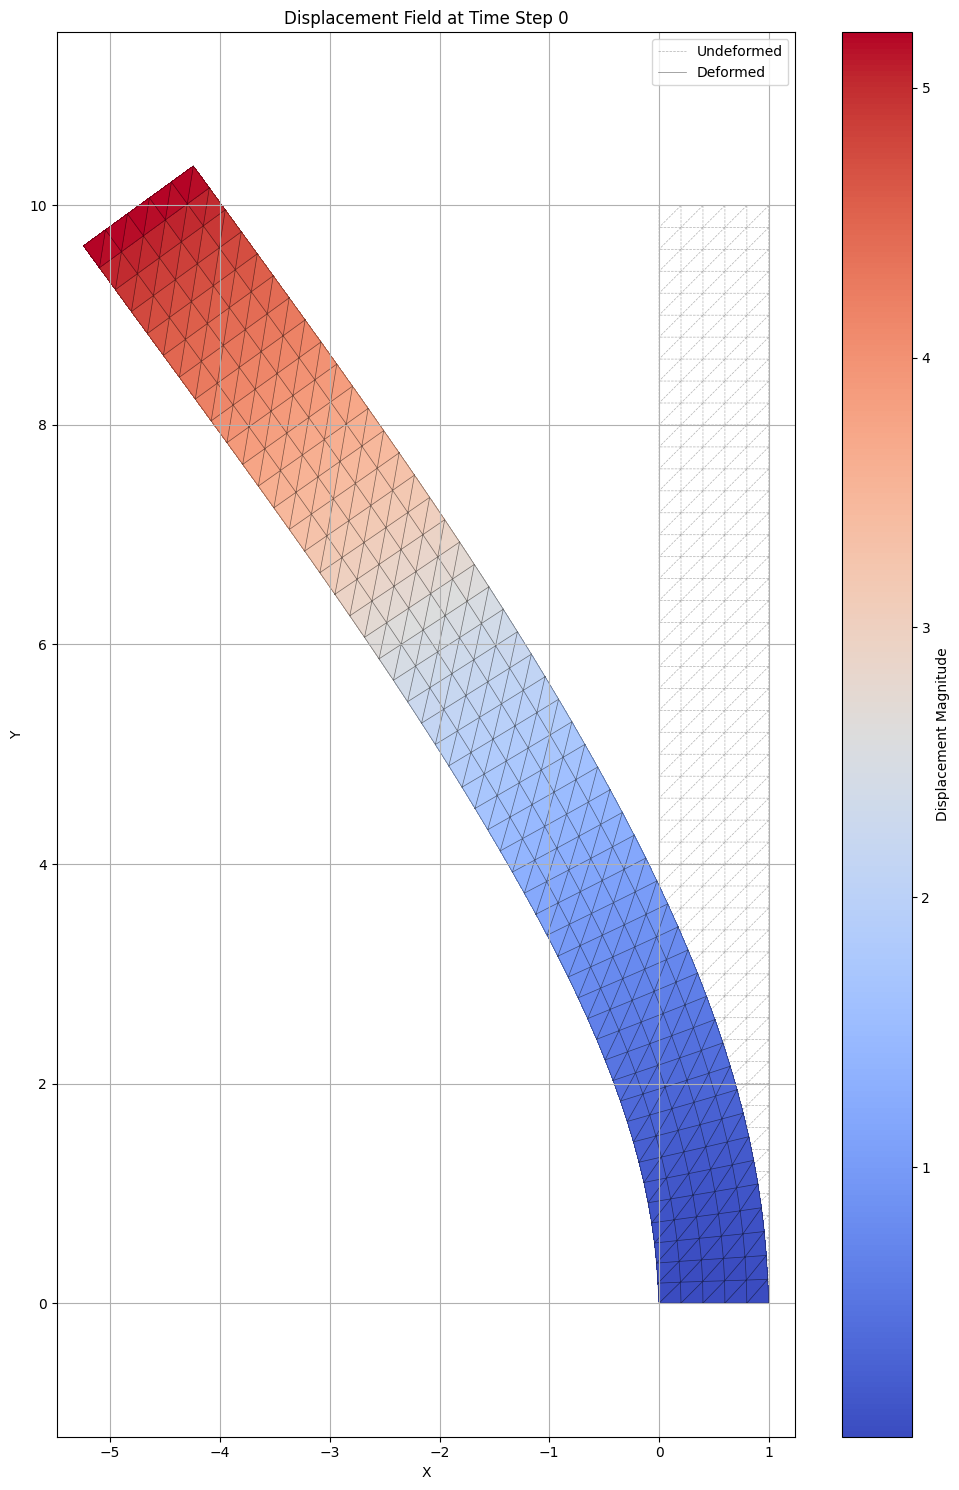


Displacement Statistics:
Maximum displacement magnitude: 5.26e+00
Minimum displacement magnitude: 0.00e+00
Mean displacement magnitude: 2.08e+00


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_displacement_timestep(x_data, time_step, mdpa_file, scale_factor=1e7):
    """
    Plot displacement field for a single time step.
    
    Parameters:
    -----------
    x_data: ndarray of shape (612, 5), displacement data
    time_step: int, which time step to plot
    mdpa_file: str, path to mdpa file
    scale_factor: float, scaling factor for displacements
    """
    # Read node coordinates and elements
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False
    
    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])
                    
            if "Begin Elements SmallDisplacementElement2D3N" in line:
                reading_elements = True
                continue
            elif reading_elements and "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                    elements.append([n1, n2, n3])
    
    node_coords = np.array(node_coords)
    elements = np.array(elements)
    
    # Get displacements for the specified time step
    displacements = x_data[:, time_step].reshape(-1, 2) * scale_factor
    disp_mag = np.sqrt(displacements[:, 0]**2 + displacements[:, 1]**2)
    
    # Calculate deformed coordinates
    deformed_coords = node_coords + displacements
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 15))
    
    # Create triangulations
    triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)
    triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
    
    # Plot undeformed mesh
    ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
    
    # Plot deformed mesh with displacement magnitude coloring
    tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm')
    ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
    
    # Add colorbar
    plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Displacement Field at Time Step {time_step}')
    ax.grid(True)
    ax.axis('equal')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print displacement statistics
    print("\nDisplacement Statistics:")
    print(f"Maximum displacement magnitude: {np.max(disp_mag):.2e}")
    print(f"Minimum displacement magnitude: {np.min(disp_mag):.2e}")
    print(f"Mean displacement magnitude: {np.mean(disp_mag):.2e}")

try:
    # Plot displacement for time step 0 (or change to any desired time step)
    plot_displacement_timestep(
        x_data=x,  # Your displacement data
        time_step=0,  # Change this to see different time steps
        mdpa_file=[file for file in os.listdir() if file.endswith('.mdpa')][0],
        scale_factor=1e6  # Adjust this to make displacements more visible
    )
except Exception as e:
    print(f"Error plotting displacement: {str(e)}")
    import traceback
    traceback.print_exc()

In [32]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.tri as tri
# import os
# from pathlib import Path

# def plot_displacement_at_timesteps(case_folder, mdpa_file, output_folder_name="displacement_plots", scale_factor=1e7):
#     """Plot displacement at each timestep and save plots as images in a new folder."""
#     try:
#         # Construct path for the new folder
#         output_folder = case_folder / output_folder_name

#         # Create the output folder if it doesn't exist
#         output_folder.mkdir(parents=True, exist_ok=True)

#         print(f"\nProcessing: {case_folder.name}")

#         # Load solution data
#         time = np.load(case_folder / "solution" / "time.npy")
#         displacement = np.load(case_folder / "solution" / "displacement.npy")

#         print(f"Loaded displacement data shape: {displacement.shape}")
#         print(f"Time steps available: {len(time)}")

#         # Read node coordinates and elements
#         node_coords = []
#         elements = []
#         reading_nodes = False
#         reading_elements = False

#         with open(mdpa_file, 'r') as file:
#             for line in file:
#                 line = line.strip()

#                 if "Begin Nodes" in line:
#                     reading_nodes = True
#                     continue
#                 elif "End Nodes" in line:
#                     reading_nodes = False
#                     continue
#                 elif reading_nodes and line:
#                     parts = line.split()
#                     if len(parts) >= 4:
#                         x, y = float(parts[1]), float(parts[2])
#                         node_coords.append([x, y])

#                 if "Begin Elements SmallDisplacementElement2D3N" in line:
#                     reading_elements = True
#                     continue
#                 elif reading_elements and "End Elements" in line:
#                     reading_elements = False
#                     continue
#                 elif reading_elements and line:
#                     parts = line.split()
#                     if len(parts) >= 5:
#                         n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
#                         elements.append([n1, n2, n3])

#         node_coords = np.array(node_coords)
#         elements = np.array(elements)

#         # Create triangulation for undeformed mesh
#         x = node_coords[:, 0]
#         y = node_coords[:, 1]
#         triangulation_orig = tri.Triangulation(x, y, elements)

#         # Find global displacement limits for consistent colorbar
#         disp_magnitudes = []
#         for step in range(len(time)):
#             disp = displacement[step].reshape(-1, 2) * scale_factor
#             disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
#             disp_magnitudes.append(disp_mag)

#         global_min = min(np.min(mag) for mag in disp_magnitudes)
#         global_max = max(np.max(mag) for mag in disp_magnitudes)

#         print(f"Plotting Information:")
#         print(f"Total plots: {len(time)}")
#         print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
#         print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

#         # Loop through timesteps and plot
#         for frame in range(len(time)):
#             # Get displacements for current frame
#             disp = displacement[frame].reshape(-1, 2) * scale_factor
#             disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)

#             # Calculate deformed coordinates
#             deformed_coords = node_coords + disp

#             # Create figure and axis for each plot
#             fig, ax = plt.subplots(figsize=(10, 15))

#             # Plot undeformed mesh
#             ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

#             # Plot deformed mesh with displacement magnitude coloring
#             triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
#             tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
#                                vmin=global_min, vmax=global_max)
#             ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

#             # Set labels and title
#             ax.set_xlabel('X')
#             ax.set_ylabel('Y')
#             ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time) - 1})')

#             ax.grid(True)
#             ax.axis('equal')
#             ax.legend()

#             # Add colorbar only once
#             if frame == 0:
#                 plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')

#             plt.tight_layout()

#             # Save plot as image
#             output_file = output_folder / f"displacement_frame_{frame:04d}.png"
#             plt.savefig(output_file)
#             plt.close(fig)

#             # Print progress
#             if frame % 10 == 0:
#                 print(f"Processed and saved plot for frame {frame}/{len(time) - 1}")

#         print("All plots completed and saved!")
#         return True

#     except Exception as e:
#         print(f"Error processing {case_folder.name}: {str(e)}")
#         return False

# def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7):
#     """Process all cases in the Dynamic_solution directory."""
#     base_path = Path(base_dir)

#     # Find all case folders dynamically
#     case_folders = list(base_path.glob("case_*_magnitude_*"))

#     # Sort case folders by case number
#     def extract_case_number(folder_name):
#         # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
#         return int(folder_name.name.split("_")[1])

#     case_folders.sort(key=extract_case_number)

#     print(f"Found {len(case_folders)} cases to process")
#     print("\nProcessing order:")
#     for folder in case_folders:
#         print(f"  {folder.name}")

#     # Process each case
#     successful = 0
#     failed = 0

#     for folder in case_folders:
#         print("\n" + "=" * 50)
#         print(f"Processing {folder.name}")
#         print("=" * 50)

#         if plot_displacement_at_timesteps(folder, mdpa_file, scale_factor=scale_factor):
#             successful += 1
#         else:
#             failed += 1

#     print("\n" + "=" * 50)
#     print("Processing Complete!")
#     print(f"Successfully processed: {successful} cases")
#     print(f"Failed to process: {failed} cases")
#     print("=" * 50)

# # Run the processing
# if __name__ == "__main__":
#     try:
#         process_all_cases(
#             base_dir="Dynamic_solution",
#             mdpa_file="2D_beam_udl_loading.mdpa",
#             scale_factor=1e6  # Adjust this if needed
#         )
#     except Exception as e:
#         print(f"Error in main execution: {str(e)}")
#         import traceback
#         traceback.print_exc()



In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from pathlib import Path

def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
    """
    Create an animated GIF of displacement field for a specific case.
    
    Parameters:
    -----------
    case_folder: Path object, full path to case folder
    mdpa_file: str, path to mdpa file
    scale_factor: float, scaling factor for displacements
    step_interval: int, time in milliseconds between frames
    """
    try:
        # Create output filename from case folder name
        output_file = case_folder / 'displacement_animation_scaled.gif'
        
        print(f"\nProcessing: {case_folder.name}")
        
        # Load solution data
        time = np.load(case_folder / "solution" / "time.npy")
        displacement = np.load(case_folder / "solution" / "displacement.npy")
        
        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")
        
        # Read node coordinates and elements
        node_coords = []
        elements = []
        reading_nodes = False
        reading_elements = False
        
        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()
                
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])
                        
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])
        
        node_coords = np.array(node_coords)
        elements = np.array(elements)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 15))
        
        # Create base triangulation for undeformed mesh
        x = node_coords[:, 0]
        y = node_coords[:, 1]
        triangulation_orig = tri.Triangulation(x, y, elements)
        
        # Find global displacement limits for consistent colorbar
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)
        
        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)
        
        print(f"Animation Information:")
        print(f"Total frames: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
        def update(frame):
            ax.clear()
            
            # Get displacements for current frame
            disp = displacement[frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
            # Calculate deformed coordinates
            deformed_coords = node_coords + disp
            
            # Plot undeformed mesh
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
            # Plot deformed mesh with displacement magnitude coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                             vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
            # Set labels and title
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            
            ax.grid(True)
            ax.axis('equal')
            ax.legend()
            
            # Add colorbar only once
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
            plt.tight_layout()
            
            # Print progress
            if frame % 10 == 0:
                print(f"Processing frame {frame}/{len(time)-1}")
        
        # Create animation
        print("Creating animation...")
        anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)
        
        # Save animation
        print(f"Saving animation to {output_file}")
        writer = PillowWriter(fps=1000/step_interval)
        anim.save(output_file, writer=writer)
        
        plt.close()
        print("Animation completed!")
        
        return True
        
    except Exception as e:
        print(f"Error processing {case_folder.name}: {str(e)}")
        return False
    
def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7):
    """Process all cases in the Dynamic_solution directory."""
    base_path = Path(base_dir)
    
    # Find all case folders dynamically
    case_folders = list(base_path.glob("case_*_magnitude_*"))
    
    # Sort case folders by case number
    def extract_case_number(folder_name):
        # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
        return int(folder_name.name.split("_")[1])
    
    case_folders.sort(key=extract_case_number)
    
    print(f"Found {len(case_folders)} cases to process")
    print("\nProcessing order:")
    for folder in case_folders:
        print(f"  {folder.name}")
    
    # Process each case
    successful = 0
    failed = 0
    
    for folder in case_folders:
        print("\n" + "="*50)
        print(f"Processing {folder.name}")
        print("="*50)
        
        # Adjust path to include Numerical_Solution subfolder
        solution_folder = folder / "Numerical_Solution"
        
        if solution_folder.exists():
            if create_displacement_animation(solution_folder, mdpa_file, scale_factor):
                successful += 1
            else:
                failed += 1
        else:
            print(f"Error: Numerical_Solution folder not found in {folder.name}")
            failed += 1
    
    print("\n" + "="*50)
    print("Processing Complete!")
    print(f"Successfully processed: {successful} cases")
    print(f"Failed to process: {failed} cases")
    print("="*50)

# Run the processing
if __name__ == "__main__":
    try:
        process_all_cases(
            base_dir="Dynamic_solution",
            mdpa_file=[file for file in os.listdir() if file.endswith('.mdpa')][0],
            scale_factor=1e6  # Adjust this if needed
        )
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

Found 2 cases to process

Processing order:
  case_1_magnitude_(257.97, -22.27, -154.57)
  case_2_magnitude_(274.33, 295.26, -167.11)

Processing case_1_magnitude_(257.97, -22.27, -154.57)

Processing: Numerical_Solution
Loaded displacement data shape: (2001, 612)
Time steps available: 2001
Animation Information:
Total frames: 2001
Time range: [0.000, 20.000] seconds
Global displacement range: [0.00e+00, 9.59e-01]
Creating animation...
Saving animation to Dynamic_solution\case_1_magnitude_(257.97, -22.27, -154.57)\Numerical_Solution\displacement_animation_scaled.gif
Processing frame 0/2000
Processing frame 0/2000
Processing frame 10/2000
Processing frame 20/2000
Processing frame 30/2000
Processing frame 40/2000
Processing frame 50/2000
Processing frame 60/2000
Processing frame 70/2000
Processing frame 80/2000
Processing frame 90/2000
Processing frame 100/2000
Processing frame 110/2000
Processing frame 120/2000
Processing frame 130/2000
Processing frame 140/2000
Processing frame 150/200

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from pathlib import Path

def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
    """
    Create an animated GIF of displacement field for a specific case.
    
    Parameters:
    -----------
    case_folder: Path object, full path to case folder
    mdpa_file: str, path to mdpa file
    scale_factor: float, scaling factor for displacements
    step_interval: int, time in milliseconds between frames
    """
    try:
        # Create output filename from case folder name
        output_file = case_folder / 'displacement_animation.gif'
        
        print(f"\nProcessing: {case_folder.name}")
        
        # Load solution data
        time = np.load(case_folder / "solution" / "time.npy")
        displacement = np.load(case_folder / "solution" / "displacement.npy")
        
        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")
        
        # Read node coordinates and elements
        node_coords = []
        elements = []
        reading_nodes = False
        reading_elements = False
        
        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()
                
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])
                        
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])
        
        node_coords = np.array(node_coords)
        elements = np.array(elements)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 15))
        
        # Create base triangulation for undeformed mesh
        x = node_coords[:, 0]
        y = node_coords[:, 1]
        triangulation_orig = tri.Triangulation(x, y, elements)
        
        # Find global displacement limits for consistent colorbar
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)
        
        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)
        
        print(f"Animation Information:")
        print(f"Total frames: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
        def update(frame):
            ax.clear()
            
            # Get displacements for current frame
            disp = displacement[frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
            # Calculate deformed coordinates
            deformed_coords = node_coords + disp
            
            # Plot undeformed mesh
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
            # Plot deformed mesh with displacement magnitude coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                             vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
            # Set labels and title
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            
            ax.grid(True)
            ax.axis('equal')
            ax.legend()
            
            # Add colorbar only once
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
            plt.tight_layout()
            
            # Print progress
            if frame % 10 == 0:
                print(f"Processing frame {frame}/{len(time)-1}")
        
        # Create animation
        print("Creating animation...")
        anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)
        
        # Save animation
        print(f"Saving animation to {output_file}")
        writer = PillowWriter(fps=1000/step_interval)
        anim.save(output_file, writer=writer)
        
        plt.close()
        print("Animation completed!")
        
        return True
        
    except Exception as e:
        print(f"Error processing {case_folder.name}: {str(e)}")
        return False
    
def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7):
    """Process all cases in the Dynamic_solution directory."""
    base_path = Path(base_dir)
    
    # Find all case folders dynamically
    case_folders = list(base_path.glob("case_*_magnitude_*"))
    
    # Sort case folders by case number
    def extract_case_number(folder_name):
        # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
        return int(folder_name.name.split("_")[1])
    
    case_folders.sort(key=extract_case_number)
    
    print(f"Found {len(case_folders)} cases to process")
    print("\nProcessing order:")
    for folder in case_folders:
        print(f"  {folder.name}")
    
    # Process each case
    successful = 0
    failed = 0
    
    for folder in case_folders:
        print("\n" + "="*50)
        print(f"Processing {folder.name}")
        print("="*50)
        
        # Adjust path to include Numerical_Solution subfolder
        solution_folder = folder / "Numerical_Solution"
        
        if solution_folder.exists():
            if create_displacement_animation(solution_folder, mdpa_file, scale_factor):
                successful += 1
            else:
                failed += 1
        else:
            print(f"Error: Numerical_Solution folder not found in {folder.name}")
            failed += 1
    
    print("\n" + "="*50)
    print("Processing Complete!")
    print(f"Successfully processed: {successful} cases")
    print(f"Failed to process: {failed} cases")
    print("="*50)

# Run the processing
if __name__ == "__main__":
    try:
        process_all_cases(
            base_dir="Dynamic_solution",
            mdpa_file=[file for file in os.listdir() if file.endswith('.mdpa')][0],
            scale_factor=1  # Adjust this if needed
        )
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

Found 2 cases to process

Processing order:
  case_1_magnitude_(101.08, -255.61, 235.94)
  case_2_magnitude_(155.21, 149.3, -93.07)

Processing case_1_magnitude_(101.08, -255.61, 235.94)

Processing: Numerical_Solution
Loaded displacement data shape: (101, 612)
Time steps available: 101
Animation Information:
Total frames: 101
Time range: [0.000, 1.000] seconds
Global displacement range: [0.00e+00, 2.72e-06]
Creating animation...
Saving animation to Dynamic_solution\case_1_magnitude_(101.08, -255.61, 235.94)\Numerical_Solution\displacement_animation.gif
Processing frame 0/100
Processing frame 0/100
Processing frame 10/100
Processing frame 20/100
Processing frame 30/100
Processing frame 40/100
Processing frame 50/100
Processing frame 60/100
Processing frame 70/100
Processing frame 80/100
Processing frame 90/100
Processing frame 100/100
Animation completed!

Processing case_2_magnitude_(155.21, 149.3, -93.07)

Processing: Numerical_Solution
Loaded displacement data shape: (101, 612)
Time

In [ ]:
# import numpy as np
# from scipy.integrate import solve_ivp
# import matplotlib.pyplot as plt
# import time
# from tqdm import tqdm
# from pathlib import Path
# from tabulate import tabulate

# s = f_constrained.shape[0]
# # Initialize initial velocity as zero vector
# v0 = np.zeros((s, f_constrained.shape[1]))

# # Assemble the matrices M* and K*
# I = np.eye(s)  # Identity matrix (s x s)
# Z = np.zeros((s, s))  # Zero matrix (s x s)

# # M* = [M 0; 0 I] (2s x 2s)
# M_star = np.block([[M_constrained, Z], [Z, I]])

# # K* = [0 K; -I 0] (2s x 2s)
# K_star = np.block([[Z, K_constrained], [-I, Z]])

# # Precompute the inverse of M*
# M_star_inv = np.linalg.inv(M_star)

# # Time span
# t_span = (0, 1)  # From t=0 to t=1

# # Define the ODE function
# def dUdt(t, U, M_star_inv, K_star, F_star):
#     """Compute dU*/dt = M*^{-1} F* - (M*^{-1} K*) U*"""
#     return M_star_inv @ (F_star - (K_star @ U))

# # Get number of cases and magnitudes
# num_cases = f_constrained.shape[1]

# # Create the base directory
# base_dir = Path("Dynamic_solution")
# base_dir.mkdir(exist_ok=True)

# # Print initial information
# print("Starting multi-case dynamic analysis...")
# print(f"Function called with:\nM: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, magnitudes: {magnitudes}, x: {x.shape}\n")
# print(f"Number of cases: {num_cases}")

# # Results storage
# results = []
# case_times = []

# # Solve the system for each case
# start_time = time.time()
# for case in tqdm(range(num_cases), desc="Solving cases"):
#     case_start_time = time.time()
#     print(f"\nSolving case {case + 1}/{num_cases}")
#     magnitude = magnitudes[case]
#     print(f"Magnitude: {magnitude}")
    
#     # Create case folder name
#     magnitude_str = ", ".join(str(val) for val in magnitude)
#     case_folder = base_dir / f"case_{case+1}_magnitude_({magnitude_str})"
#     analytical_folder = case_folder / "Analytical_Solution"
#     analytical_folder.mkdir(parents=True, exist_ok=True)
    
#     # Solve the system
#     U0 = np.concatenate((v0[:, case], x[:, case]))  # Initial state vector
#     F_star = np.concatenate((f_constrained[:, case], np.zeros(s)))  # Force vector
    
#     # Solve ODE
#     sol = solve_ivp(dUdt, t_span, U0, args=(M_star_inv, K_star, F_star), t_eval=np.linspace(t_span[0], t_span[1], 100),
#                     method='Radau', rtol=1e-8)
    
#     # Extract results
#     t = sol.t
#     U = sol.y
#     v = U[:s]  # Velocity
#     u = U[s:]  # Displacement
#     a = np.gradient(v, t, axis=1)  # Acceleration
    
#     # Save results
#     np.save(analytical_folder / 'time.npy', t)
#     np.save(analytical_folder / 'displacement.npy', u)
#     np.save(analytical_folder / 'velocity.npy', v)
#     np.save(analytical_folder / 'acceleration.npy', a)
    
#     # Store summary results
#     case_time = time.time() - case_start_time
#     case_times.append(case_time)
    
#     results.append({
#         "case": case + 1,
#         "magnitude": magnitude,
#         "max_displacement": np.max(np.abs(u)),
#         "max_velocity": np.max(np.abs(v)),
#         "max_acceleration": np.max(np.abs(a)),
#         "solve_time": case_time
#     })
    
#     print(f"Case {case + 1} completed in {case_time:.2f} seconds.")
#     print(f"Results saved to {analytical_folder}")

# # Print results summary
# print("\nResults Summary:")
# print("=" * 80)
# summary_data = [[r["case"], 
#                 str(r["magnitude"]), 
#                 f"{r['max_displacement']:.2e}",
#                 f"{r['max_velocity']:.2e}", 
#                 f"{r['max_acceleration']:.2e}",
#                 f"{r['solve_time']:.2f}"] for r in results]

# headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
# print(tabulate(summary_data, headers=headers, tablefmt="grid"))

# # Print overall statistics
# total_time = sum(case_times)
# print("\nOverall Statistics:")
# print("=" * 80)
# print(f"Total computation time: {total_time:.2f} seconds")
# print(f"Average time per case: {total_time/num_cases:.2f} seconds")
# print(f"Number of cases: {num_cases}")
# print(f"Fastest case: {min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
# print(f"Slowest case: {max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

# print(f"\nAnalysis complete. Results saved in: {base_dir.resolve()}")

Starting multi-case dynamic analysis...
Function called with:
M: (612, 612), K: (612, 612), f: (612, 1), magnitudes: [(-66.78, 279.76, 305.9)], x: (612, 1)

Number of cases: 1


Solving cases:   0%|          | 0/1 [00:00<?, ?it/s]


Solving case 1/1
Magnitude: (-66.78, 279.76, 305.9)


Solving cases: 100%|██████████| 1/1 [00:50<00:00, 50.08s/it]

Case 1 completed in 50.08 seconds.
Results saved to Dynamic_solution\case_1_magnitude_(-66.78, 279.76, 305.9)\Analytical_Solution

Results Summary:
+--------+-------------------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude               |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+=========================+====================+================+====================+==================+
|      1 | (-66.78, 279.76, 305.9) |           6.81e-05 |         0.0022 |              0.117 |            50.08 |
+--------+-------------------------+--------------------+----------------+--------------------+------------------+

Overall Statistics:
Total computation time: 50.08 seconds
Average time per case: 50.08 seconds
Number of cases: 1
Fastest case: 50.08 seconds (Case 1)
Slowest case: 50.08 seconds (Case 1)

Analysis complete. Results saved in: D:\Git_clone\Thesis_Cleaned\2D_beam_udl_loading\Dy

In [33]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate

# Get system dimensions
n_dof = M_constrained.shape[0]  # Number of degrees of freedom
n_cases = f_constrained.shape[0]  # Number of load cases

# Define x using the same values as x_analtical
# x0 = np.zeros((1,n_dof)) # Displacement (m) as a 1x1 matrix
x0 = x.flatten()  # Converts a 2D array to 1D if needed


s = f_constrained.shape[0]
# Initialize initial velocity as zero vector
# v0 = np.zeros((n_dof))  # Initial velocities (n×m)
v0 = np.zeros_like(x0)  # This will make sure v0 has the same shape as x0


y0 = np.vstack([x0, v0])  # Stack initial conditions into a column vector|

# Time step and total simulation time
dt = 0.01               # Time step = T/200
total_time = 20          # Total simulation time

# Calculate number of steps
n_steps = int(total_time / dt) + 1

# Compute M⁻¹
M_inv = np.linalg.inv(M_constrained)

print(np.zeros((n_dof,1)).shape)
prod = M_inv@f_constrained
print(prod.shape)

# Define system matrix A and input vector B
A = np.block([
    [np.zeros((n_dof, n_dof)), np.eye(n_dof)], 
    [-M_inv @ K_constrained, np.zeros((n_dof, n_dof))]
])

B = np.vstack([np.zeros((n_dof, 1)), M_inv @ f_constrained])

# Time span
t_span = (0, total_time)  # From t=0 to t=1
t_eval = np.linspace(0, total_time, n_steps)  # Time points where the solution is evaluated

def dUdt(t, y):
    return A @ y + B.flatten()


# Get number of cases and magnitudes
num_cases = f_constrained.shape[1]

# Create the base directory
base_dir = Path("Dynamic_solution")
base_dir.mkdir(exist_ok=True)

# Print initial information
print("Starting multi-case dynamic analysis...")
print(f"Function called with:\nM: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, magnitudes: {magnitudes}, x: {x0.shape}\n")
print(f"Number of cases: {num_cases}")

# Results storage
results = []
case_times = []

# Solve the system for each case
start_time = time.time()
for case in tqdm(range(num_cases), desc="Solving cases"):
    case_start_time = time.time()
    print(f"\nSolving case {case + 1}/{num_cases}")
    magnitude = magnitudes[case]
    print(f"Magnitude: {magnitude}")
    
    # Create case folder name
    magnitude_str = ", ".join(str(val) for val in magnitude)
    case_folder = base_dir / f"case_{case+1}_magnitude_({magnitude_str})"
    analytical_folder = case_folder / "Analytical_Solution"
    analytical_folder.mkdir(parents=True, exist_ok=True)

    # Solve the system
    sol = solve_ivp(dUdt, t_span, y0, t_eval=t_eval, method='RK45', atol=1e-10, rtol=1e-10)
    
    # Extract results
    t = sol.t
    U = sol.y
    u = U[:s]  # Velocity
    v = U[s:]  # Displacement
    a = np.linalg.solve(M_constrained, f_constrained - (K_constrained @ u))  # Acceleration
    
    # Save results
    np.save(analytical_folder / 'time.npy', t)
    np.save(analytical_folder / 'displacement.npy', u)
    np.save(analytical_folder / 'velocity.npy', v)
    np.save(analytical_folder / 'acceleration.npy', a)
    
    # Store summary results
    case_time = time.time() - case_start_time
    case_times.append(case_time)
    
    results.append({
        "case": case + 1,
        "magnitude": magnitude,
        "max_displacement": np.max(np.abs(u)),
        "max_velocity": np.max(np.abs(v)),
        "max_acceleration": np.max(np.abs(a)),
        "solve_time": case_time
    })
    
    print(f"Case {case + 1} completed in {case_time:.2f} seconds.")
    print(f"Results saved to {analytical_folder}")

# Print results summary
print("\nResults Summary:")
print("=" * 80)
summary_data = [[r["case"], 
                str(r["magnitude"]), 
                f"{r['max_displacement']:.2e}",
                f"{r['max_velocity']:.2e}", 
                f"{r['max_acceleration']:.2e}",
                f"{r['solve_time']:.2f}"] for r in results]

headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))

# Print overall statistics
total_time = sum(case_times)
print("\nOverall Statistics:")
print("=" * 80)
print(f"Total computation time: {total_time:.2f} seconds")
print(f"Average time per case: {total_time/num_cases:.2f} seconds")
print(f"Number of cases: {num_cases}")
print(f"Fastest case: {min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
print(f"Slowest case: {max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

# Print maximum values for each mode
for mode in range(u.shape[0]):
    print(f"Mode {mode + 1}:")
    print(f"  Maximum displacement: {np.max(np.abs(u[mode, :])):.2e}")
    print(f"  Maximum velocity: {np.max(np.abs(v[mode, :])):.2e}")
    print(f"  Maximum acceleration: {np.max(np.abs(a[mode, :])):.2e}")

print(f"\nAnalysis complete. Results saved in: {base_dir.resolve()}")

max_displacement_combined = np.sum([np.max(np.abs(u[mode, :])) for mode in range(u.shape[0])])
print(f"\nMaximum displacement considering both modes: {max_displacement_combined}")
print(np.max(np.abs(u)))

(612, 1)
(612, 1)
Starting multi-case dynamic analysis...
Function called with:
M: (612, 612), K: (612, 612), f: (612, 1), magnitudes: [(-66.78, 279.76, 305.9)], x: (612,)

Number of cases: 1


Solving cases:   0%|          | 0/1 [00:00<?, ?it/s]


Solving case 1/1
Magnitude: (-66.78, 279.76, 305.9)


ValueError: `y0` must be 1-dimensional.

In [34]:
# MDOF System Solver using State-Space Approach (Using MATLAB Logic)

import numpy as np
from scipy.integrate import solve_ivp
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate


def mdof_system_dynamics(t, y, A, B):
    return A @ y + B.flatten()


def solve_mdof(M, K, f, magnitudes, X, total_time, dt):
    n_dof = M.shape[0]
    num_cases = f.shape[1]
    time_steps = np.arange(0, total_time, dt)
    t_span = (0, total_time)

    M_inv = np.linalg.inv(M)  # Compute once and reuse
    MK_product = M_inv @ K  # Pre-compute M^-1 * K

    results = []
    case_times = []

    print("\nStarting multi-case dynamic analysis...\n")
    print(f"Number of cases: {num_cases}")
    print(f"System DOFs: {n_dof}")

    for case in tqdm(range(num_cases), desc="Solving cases"):
        F = f[:, case]  # Extract force vector for the current case
        initial_displacement = X[:, case]  # Extract initial displacement for the current case
        initial_velocity = np.zeros(n_dof)

        # Ensure y0 is correctly initialized
        y0 = np.concatenate([initial_displacement.flatten(), initial_velocity.flatten()])

        # Define system matrix A
        A = np.block([
            [np.zeros((n_dof, n_dof)), np.eye(n_dof)],
            [-MK_product, np.zeros((n_dof, n_dof))]  # Reusing precomputed MK_product
        ])

        # Create the B matrix ensuring it matches dimensions
        F_case = M_inv @ F  # Directly use the force vector for this case
        B = np.hstack([np.zeros(n_dof), F_case]).reshape(-1, 1)

        case_start_time = time.time()

        # Solving using solve_ivp
        sol = solve_ivp(mdof_system_dynamics, t_span, y0, t_eval=time_steps, args=(A, B), method='RK45', rtol=1e-10, atol=1e-10)

        U = sol.y
        displacement = U[:n_dof, :]
        velocity = U[n_dof:, :]

        # Compute acceleration at each time step (using precomputed MK_product)
        acceleration = np.array([np.linalg.solve(M, F - K @ displacement[:, i]) for i in range(len(time_steps))])

        case_time = time.time() - case_start_time
        case_times.append(case_time)

        results.append({
            "case": case + 1,
            "magnitude": magnitudes[case],
            "max_displacement": np.max(np.abs(displacement)),
            "max_velocity": np.max(np.abs(velocity)),
            "max_acceleration": np.max(np.abs(acceleration)),
            "solve_time": case_time
        })

        print(f"\nCase {case + 1}/{num_cases} completed in {case_time:.2f} seconds.")
        print(f"Maximum Displacement: {np.max(np.abs(displacement)):.2e}")
        print(f"Maximum Velocity: {np.max(np.abs(velocity)):.2e}")
        print(f"Maximum Acceleration: {np.max(np.abs(acceleration)):.2e}\n")

    return results, case_times


# Example Usage
# Matrices M, K, f_constrained, X, and magnitudes are already defined externally.


In [35]:
# Define time parameters
total_time = 1.0   # Total simulation time (adjust as needed)
dt = 0.01           # Time step size

# Call the function with your matrices
results, case_times = solve_mdof(
    M=M_constrained,
    K=K_constrained,
    f=f_constrained,
    magnitudes=magnitudes,
    X=x,
    total_time=total_time,
    dt=dt
)



Starting multi-case dynamic analysis...

Number of cases: 1
System DOFs: 612


Solving cases: 100%|██████████| 1/1 [04:21<00:00, 261.43s/it]


Case 1/1 completed in 261.42 seconds.
Maximum Displacement: 6.81e-05
Maximum Velocity: 2.26e-03
Maximum Acceleration: 5.88e+00



In [ ]:
# MDOF System Solver using State-Space Approach (Using MATLAB Logic)

import numpy as np
from scipy.integrate import solve_ivp
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate


def mdof_system_dynamics(t, y, A, B):
    return A @ y + B.flatten()


def solve_mdof(M, K, f, magnitudes, x, total_time, dt):
    n_dof = M.shape[0]
    num_cases = f.shape[1]
    time_steps = np.arange(0, total_time, dt)
    t_span = (0, total_time)

    M_inv = np.linalg.inv(M)

    results = []
    case_times = []

    for case in tqdm(range(num_cases), desc="Solving cases"):
        F = f[:, case]  # Extract force vector for the current case
        initial_displacement = x[:, case]  # Extract initial displacement for the current case
        initial_velocity = np.zeros(n_dof)

        # Ensure y0 is of size 2*n_dof
        y0 = np.concatenate([initial_displacement.flatten(), initial_velocity.flatten()])

        # Define system matrix A and input matrix B (Based on MATLAB logic)
        A = np.block([
            [np.zeros((n_dof, n_dof)), np.eye(n_dof)],
            [-M_inv @ K, np.zeros((n_dof, n_dof))]
        ])

        F_case = M_inv @ F.reshape(-1, 1)  # Ensure force is a column vector
        B = np.vstack([np.zeros((n_dof, 1)), F_case])  # B must have size (2*n_dof, 1)

        case_start_time = time.time()

        # Solving using solve_ivp
        sol = solve_ivp(mdof_system_dynamics, t_span, y0, t_eval=time_steps, args=(A, B), method='RK45')

        U = sol.y
        displacement = U[:n_dof, :]
        velocity = U[n_dof:, :]

        # Compute acceleration at each time step
        acceleration = np.array([np.linalg.solve(M, F - K @ displacement[:, i]) for i in range(len(time_steps))])

        case_time = time.time() - case_start_time
        case_times.append(case_time)

        results.append({
            "case": case + 1,
            "magnitude": magnitudes[case],
            "max_displacement": np.max(np.abs(displacement)),
            "max_velocity": np.max(np.abs(velocity)),
            "max_acceleration": np.max(np.abs(acceleration)),
            "solve_time": case_time
        })

    return results, case_times


# Example Usage
# Matrices M, K, f, x, and magnitudes are already defined externally.


In [ ]:
# Define your matrices and input values
M = M_constrained          # Your mass matrix (e.g., shape (612, 612))
K = K_constrained          # Your stiffness matrix (e.g., shape (612, 612))
f = f_constrained          # Your force matrix (e.g., shape (612, num_cases))
x = x                      # Your initial displacement matrix (e.g., shape (612, num_cases))
magnitudes = magnitudes    # List of magnitudes for each case (e.g., [(1.0, 0.5), (2.0, 1.0)])

# Time-related parameters
total_time = 20.0          # Total simulation time
dt = 0.01                  # Time step size

results, case_times = solve_mdof(M, K, f, magnitudes, x, total_time, dt)
# def solve_mdof(M, K, f, magnitudes, x, total_time, dt):

# Print results summary
print("\nResults Summary:")
print("=" * 80)
summary_data = [[r["case"], r["magnitude"], f"{r['max_displacement']:.2e}", f"{r['max_velocity']:.2e}", f"{r['max_acceleration']:.2e}", f"{r['solve_time']:.2f}"] for r in results]

headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))




Solving cases:   0%|          | 0/2 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 614 is different from 1224)

In [45]:
# MDOF System Solver using State-Space Approach

import numpy as np
from scipy.integrate import solve_ivp
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate


def mdof_system_dynamics(t, y, M, K, F):
    n = M.shape[0]
    x = y[:n]
    x_dot = y[n:]

    # Compute acceleration
    x_ddot = np.linalg.solve(M, F - K @ x)

    return np.concatenate((x_dot, x_ddot))


def solve_mdof(M, K, f, magnitudes, x, total_time, dt):
    n_dof = M.shape[0]
    num_cases = f.shape[1]
    time_steps = np.arange(0, total_time, dt)
    t_span = (0, total_time)

    results = []
    case_times = []

    for case in tqdm(range(num_cases), desc="Solving cases"):
        F = f[:, case]
        initial_displacement = x[:, case]
        initial_velocity = np.zeros(n_dof)
        y0 = np.concatenate((initial_displacement, initial_velocity))

        case_start_time = time.time()

        sol = solve_ivp(mdof_system_dynamics, t_span, y0, t_eval=time_steps, args=(M, K, F), method='RK45')

        displacement = sol.y[:n_dof, :].T
        velocity = sol.y[n_dof:, :].T
        # acceleration = np.array([np.linalg.solve(M, F - K @ displacement[i, :]) for i in range(len(time))])
        acceleration = np.array([np.linalg.solve(M, F - K @ displacement[i, :]) for i in range(len(time_steps))])



        case_time = time.time() - case_start_time
        case_times.append(case_time)

        results.append({
            "case": case + 1,
            "magnitude": magnitudes[case],
            "max_displacement": np.max(np.abs(displacement)),
            "max_velocity": np.max(np.abs(velocity)),
            "max_acceleration": np.max(np.abs(acceleration)),
            "solve_time": case_time
        })

    return results, case_times


# Example Usage
M = np.array([[2.0, 0.0], [0.0, 1.0]])  # Mass matrix
K = np.array([[10.0, -2.0], [-2.0, 5.0]])  # Stiffness matrix
f = np.zeros((2, 1))  # External force for one case
magnitudes = [(1.0, 0.5)]
x = np.array([[1.0, 0.0], [0.5, 0.0]])

total_time = 0.01
dt = 3.14e-6

results, case_times = solve_mdof(M, K, f, magnitudes, x, total_time, dt)

# Print results summary
print("\nResults Summary:")
print("=" * 80)
summary_data = [[r["case"], r["magnitude"], f"{r['max_displacement']:.2e}", f"{r['max_velocity']:.2e}", f"{r['max_acceleration']:.2e}", f"{r['solve_time']:.2f}"] for r in results]

headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))


Solving cases: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


Results Summary:
+--------+-------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude   |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+=============+====================+================+====================+==================+
|      1 | (1.0, 0.5)  |                  1 |          0.045 |                4.5 |             0.04 |
+--------+-------------+--------------------+----------------+--------------------+------------------+


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from pathlib import Path
import traceback

def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
    """
    Create an animated GIF of displacement field for a specific case.
    
    Parameters:
    -----------
    case_folder: Path object, full path to case folder
    mdpa_file: str, path to mdpa file
    scale_factor: float, scaling factor for displacements
    step_interval: int, time in milliseconds between frames
    """
    try:
        # Create output filename from case folder name
        output_file = case_folder / 'displacement_animation.gif'
        
        print(f"\nProcessing: {case_folder.name}")
        
        # Load solution data
        time = np.load(case_folder / "time.npy")
        displacement = np.load(case_folder / "displacement.npy")
        
        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")
        
        # Read node coordinates and elements
        node_coords = []
        elements = []
        reading_nodes = False
        reading_elements = False
        
        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()
                
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])
                        
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])
        
        node_coords = np.array(node_coords)
        elements = np.array(elements)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 15))
        
        # Create base triangulation for undeformed mesh
        x = node_coords[:, 0]
        y = node_coords[:, 1]
        triangulation_orig = tri.Triangulation(x, y, elements)
        
        # Find global displacement limits for consistent colorbar
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[:, step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)
        
        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)
        
        print(f"Animation Information:")
        print(f"Total frames: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
        def update(frame):
            ax.clear()
            
            # Get displacements for current frame
            disp = displacement[:, frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
            # Calculate deformed coordinates
            deformed_coords = node_coords + disp
            
            # Plot undeformed mesh
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
            # Plot deformed mesh with displacement magnitude coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                             vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
            # Set labels and title
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            
            ax.grid(True)
            ax.axis('equal')
            ax.legend()
            
            # Add colorbar only once
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
            plt.tight_layout()
            
            # Print progress
            if frame % 10 == 0:
                print(f"Processing frame {frame}/{len(time)-1}")
        
        # Create animation
        print("Creating animation...")
        anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)
        
        # Save animation
        print(f"Saving animation to {output_file}")
        writer = PillowWriter(fps=1000/step_interval)
        anim.save(output_file, writer=writer)
        
        plt.close()
        print("Animation completed!")
        
        return True
        
    except Exception as e:
        print(f"Error processing {case_folder.name}: {str(e)}")
        traceback.print_exc()
        return False
    
def process_all_cases(base_dir="Dynamic_solution", scale_factor=1e7):
    """Process all cases in the Dynamic_solution directory."""
    base_path = Path(base_dir)
    
    # Find all case folders dynamically
    case_folders = list(base_path.glob("case_*_magnitude_*/Analytical_Solution"))
    
    # Sort case folders by case number
    def extract_case_number(folder_name):
        # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
        return int(folder_name.parts[-2].split("_")[1])
    
    case_folders.sort(key=extract_case_number)
    
    print(f"Found {len(case_folders)} cases to process")
    print("\nProcessing order:")
    for folder in case_folders:
        print(f"  {folder.parent.name}")
    
    # Find the .mdpa file in the current working directory
    cwd = Path.cwd()
    mdpa_file = next((f for f in cwd.glob("*.mdpa")), None)
    if mdpa_file is None:
        raise FileNotFoundError("No .mdpa file found in the current directory.")
    
    print(f"Using .mdpa file: {mdpa_file}")
    
    # Process each case
    successful = 0
    failed = 0
    
    for folder in case_folders:
        print("\n" + "="*50)
        print(f"Processing {folder.parent.name}")
        print("="*50)
        
        if create_displacement_animation(folder, mdpa_file, scale_factor):
            successful += 1
        else:
            failed += 1
    
    print("\n" + "="*50)
    print("Processing Complete!")
    print(f"Successfully processed: {successful} cases")
    print(f"Failed to process: {failed} cases")
    print("="*50)

# Run the processing
if __name__ == "__main__":
    try:
        process_all_cases(
            base_dir="Dynamic_solution",
            scale_factor=1e6  # Adjust this if needed   
        )
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        traceback.print_exc()

Found 0 cases to process

Processing order:
Using .mdpa file: d:\Git_clone\Thesis_Cleaned\2D_beam_udl_loading\2D_beam_udl_loading.mdpa

Processing Complete!
Successfully processed: 0 cases
Failed to process: 0 cases


In [ ]:
def solve_with_solve_ivp(M_constrained, K_constrained, x, f_constrained, t_total=1.0, n_divisions=100):
    # Get dimensions
    n_dof, n_cases = x.shape
    
    # Precompute inverse of mass matrix
    M_inv = np.linalg.inv(M_constrained)
    
    # Time parameters
    t_eval = np.linspace(0, t_total, n_divisions + 1)
    
    # Initialize arrays
    u_results = np.zeros((n_divisions + 1, n_dof, n_cases))
    v_results = np.zeros((n_divisions + 1, n_dof, n_cases))
    a_results = np.zeros((n_divisions + 1, n_dof, n_cases))
    
    # Define zero initial velocity matrix
    v0_matrix = np.zeros_like(x)
    
    # Solve for each case
    for case in range(n_cases):
        u0 = x[:, case]
        v0 = v0_matrix[:, case]
        F = f_constrained[:, case]
        
        # Initial state vector
        y0 = np.concatenate([u0, v0])
        
        # Solver with jit_function option to compile the RHS function
        sol = solve_ivp(
            lambda t, y: np.concatenate([
                y[n_dof:], 
                M_inv @ (F - K_constrained @ y[:n_dof])
            ]),
            (0, t_total),
            y0,
            t_eval=t_eval,
            method='Radau',  # Use Radau which is good for stiff problems
            # rtol=1e-3,       # Looser tolerance for speed
            # atol=1e-6
        )
        
        # Extract results
        u_results[:, :, case] = sol.y[:n_dof, :].T
        v_results[:, :, case] = sol.y[n_dof:, :].T
        
        # Calculate accelerations
        for i in range(n_divisions + 1):
            a_results[i, :, case] = M_inv @ (F - K_constrained @ u_results[i, :, case])
    
    return u_results, v_results, a_results

In [ ]:
# Call the optimized solver
u_results, v_results, a_results = solve_dynamic_system_cas(
    M_constrained, K_constrained, x, f_constrained, 
    t_total=1.0, n_divisions=100
)

# Results are in shape (n_steps+1, n_dof, n_cases)
# u_results[i,j,k] is the displacement of DOF j at time step i for case k
# v_results[i,j,k] is the velocity of DOF j at time step i for case k
# a_results[i,j,k] is the acceleration of DOF j at time step i for case k

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from pathlib import Path
import time

def system_of_odes(t, y, M_inv, K, F):
    """
    Define the system of ODEs for the dynamic system.
    """
    x, v = y[:len(M_inv)], y[len(M_inv):]
    dxdt = v
    dvdt = M_inv @ (F - K @ x)  # Use precomputed M_inv
    return np.concatenate((dxdt, dvdt))

def save_case_results(results, case_dir, prefix="analytical"):
    """
    Save results for a single case with comprehensive solution storage.
    """
    # Create solution directory
    solution_dir = case_dir / 'solution'
    solution_dir.mkdir(exist_ok=True)
    
    # Save raw solution arrays as .npy files
    np.save(solution_dir / f'{prefix}_time.npy', results['time'])
    np.save(solution_dir / f'{prefix}_displacement.npy', results['displacement'])
    np.save(solution_dir / f'{prefix}_velocity.npy', results['velocity'])
    np.save(solution_dir / f'{prefix}_acceleration.npy', results['acceleration'])
    
    # Save time history data in compressed format
    np.savez(case_dir / f'{prefix}_time_history.npz',
             time=results['time'],
             displacement=results['displacement'],
             velocity=results['velocity'],
             acceleration=results['acceleration'])
    
    # Save summary statistics
    with open(case_dir / f'{prefix}_summary.txt', 'w') as f:
        f.write("Results Summary:\n")
        f.write("=" * 50 + "\n")
        f.write(f"Time steps completed: {len(results['time'])}\n")
        f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
        f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
        f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
        f.write("\nFile Locations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Solution arrays (.npy files): {solution_dir}\n")
        f.write(f"Time history: {case_dir/f'{prefix}_time_history.npz'}\n")

def solve_dynamic_system(M, K, F, x0, t_span, t_eval, case_dir):
    """
    Solve the dynamic system for a single case and save the results.
    """
    # Precompute the inverse of the mass matrix
    M_inv = np.linalg.inv(M)
    
    # Initial conditions
    v0 = np.zeros_like(x0)
    y0 = np.concatenate((x0, v0))
    
    # Solve the ODE
    sol = solve_ivp(system_of_odes, t_span, y0, args=(M_inv, K, F), t_eval=t_eval, method='RK45')
    
    # Extract results
    displacement = sol.y[:len(M), :]
    velocity = sol.y[len(M):, :]
    acceleration = np.gradient(velocity, t_eval, axis=1)
    
    # Prepare results dictionary
    results = {
        'time': t_eval,
        'displacement': displacement,
        'velocity': velocity,
        'acceleration': acceleration
    }
    
    # Save results
    save_case_results(results, case_dir)

# Example usage
# M_constrained = np.array(...)  # Mass matrix (612, 612)
# K_constrained = np.array(...)  # Stiffness matrix (612, 612)
# f_constrained = np.array(...)  # Force vector (612, num_cases)
# x = np.array(...)  # Initial displacement (612, num_cases)

# Determine the number of cases
num_cases = f_constrained.shape[1]

# Define time span and evaluation points
t_span = (0, 1)  # Example time span
t_eval = np.linspace(t_span[0], t_span[1], num=100)  # Time points for evaluation

# Start time tracking
start_time = time.time()

# Loop through each case
for case_idx in range(num_cases):
    case_dir = Path(f"case_{case_idx}")
    case_dir.mkdir(exist_ok=True)
    
    # Extract force and initial displacement for the current case
    F = f_constrained[:, case_idx]
    x0 = x[:, case_idx]
    
    # Print progress
    print(f"Solving Case {case_idx + 1}/{num_cases}...")
    
    # Solve the dynamic system for the current case
    solve_dynamic_system(M_constrained, K_constrained, F, x0, t_span, t_eval, case_dir)
    
    # Print time elapsed for the current case
    case_time = time.time() - start_time
    print(f"Case {case_idx + 1} completed in {case_time:.2f} seconds.")

# Total time elapsed
total_time = time.time() - start_time
print(f"All cases completed in {total_time:.2f} seconds.")

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from pathlib import Path
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def system_of_odes(t, y, M_inv, M_inv_K, F):
    """
    Define the system of ODEs for the dynamic system.
    """
    print(f"Solving at time t = {t}")
    x, v = y[:len(M_inv)], y[len(M_inv):]
    dxdt = v
    # dvdt = M_inv @ (F - K @ x)  # Use precomputed M_inv
    dvdt = M_inv @ F - M_inv_K @ x
    return np.concatenate((dxdt, dvdt))

def save_case_results(results, case_dir, prefix="analytical"):
    """
    Save results for a single case with comprehensive solution storage.
    """
    # Create solution directory
    solution_dir = case_dir / 'solution'
    solution_dir.mkdir(exist_ok=True)
    
    # Save raw solution arrays as .npy files
    np.save(solution_dir / f'{prefix}_time.npy', results['time'])
    np.save(solution_dir / f'{prefix}_displacement.npy', results['displacement'])
    np.save(solution_dir / f'{prefix}_velocity.npy', results['velocity'])
    np.save(solution_dir / f'{prefix}_acceleration.npy', results['acceleration'])
    
    # Save time history data in compressed format
    np.savez(case_dir / f'{prefix}_time_history.npz',
             time=results['time'],
             displacement=results['displacement'],
             velocity=results['velocity'],
             acceleration=results['acceleration'])
    
    # Save summary statistics
    with open(case_dir / f'{prefix}_summary.txt', 'w') as f:
        f.write("Results Summary:\n")
        f.write("=" * 50 + "\n")
        f.write(f"Time steps completed: {len(results['time'])}\n")
        f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
        f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
        f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
        f.write("\nFile Locations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Solution arrays (.npy files): {solution_dir}\n")
        f.write(f"Time history: {case_dir/f'{prefix}_time_history.npz'}\n")

# def solve_dynamic_system(M, K, F, x0, t_span, t_eval, case_dir, magnitude):
#     """
#     Solve the dynamic system for a single case and save the results.
#     """
#     # Precompute the inverse of the mass matrix
#     M_inv = np.linalg.inv(M)
    
#     # Initial conditions
#     v0 = np.zeros_like(x0)
#     y0 = np.concatenate((x0, v0))
    
#     # Solve the ODE
#     sol = solve_ivp(system_of_odes, t_span, y0, args=(M_inv, K, F), t_eval=t_eval, method='RK45')
    
#     # Extract results
#     displacement = sol.y[:len(M), :]
#     velocity = sol.y[len(M):, :]
#     acceleration = np.gradient(velocity, t_eval, axis=1)
    
#     # Prepare results dictionary
#     results = {
#         'time': t_eval,
#         'displacement': displacement,
#         'velocity': velocity,
#         'acceleration': acceleration
#     }
    
#     # Save results
#     save_case_results(results, case_dir)
    
#     # Generate animation
#     generate_animation(results, case_dir, magnitude)
    
#     return results

def solve_dynamic_system(M, K, F, x0, t_span, t_eval, case_dir, magnitude):
    """
    Solve the dynamic system for a single case and save the results.
    """
    # Precompute the inverse of the mass matrix
    M_inv = np.linalg.inv(M)
    
    # Precompute M_inv @ K for efficiency
    M_inv_K = M_inv @ K
    
    # Initial conditions
    v0 = np.zeros_like(x0)
    y0 = np.concatenate((x0, v0))
    
    # Solve the ODE
    sol = solve_ivp(
        system_of_odes, 
        t_span, 
        y0, 
        args=(M_inv, M_inv_K, F), 
        t_eval=t_eval, 
        method='BDF',  # Use a stiff solver
        atol=1e-6,     # Absolute tolerance
        rtol=1e-6      # Relative tolerance
    )
    
    # Extract results
    displacement = sol.y[:len(M), :]
    velocity = sol.y[len(M):, :]
    acceleration = M_inv @ (F[:, np.newaxis] - K @ displacement)
    
    # Prepare results dictionary
    results = {
        'time': t_eval,
        'displacement': displacement,
        'velocity': velocity,
        'acceleration': acceleration
    }
    
    # Save results
    save_case_results(results, case_dir)
    
    # Generate animation
    generate_animation(results, case_dir, magnitude)
    
    return results

def generate_animation(results, case_dir, magnitude):
    """
    Generate an animation of the displacement over time and save it as a GIF.
    """
    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)
    ax.set_xlim(min(results['time']), max(results['time']))
    ax.set_ylim(np.min(results['displacement']), np.max(results['displacement']))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Displacement')
    ax.set_title(f'Case Magnitude: {magnitude}')
    
    def animate(i):
        line.set_data(results['time'][:i], results['displacement'][0, :i])
        return line,
    
    ani = animation.FuncAnimation(fig, animate, frames=len(results['time']), interval=50, blit=True)
    ani.save(case_dir / 'displacement_animation.gif', writer='pillow')
    plt.close()

# def print_summary_table(results_list, magnitudes, solve_times):
#     """
#     Print a summary table of the results.
#     """
#     print("\nResults Summary:")
#     print("=" * 80)
#     print(f"{'Case':<6} | {'Magnitude':<30} | {'Max Displacement':<18} | {'Max Velocity':<14} | {'Max Acceleration':<18} | {'Solve Time (s)':<14}")
#     print("=" * 80)
#     for i, (results, magnitude, solve_time) in enumerate(zip(results_list, magnitudes, solve_times)):
#         max_disp = np.max(np.abs(results['displacement']))
#         max_vel = np.max(np.abs(results['velocity']))
#         max_acc = np.max(np.abs(results['acceleration']))
#         print(f"{i+1:<6} | {str(magnitude):<30} | {max_disp:.2e} | {max_vel:.2e} | {max_acc:.2e} | {solve_time:.2f}")
#     print("=" * 80)

def print_summary_table(results_list, magnitudes, solve_times):
    """
    Print a well-aligned summary table of the results.
    """
    # Define column widths
    col_widths = {
        'case': 6,
        'magnitude': 30,
        'max_disp': 18,
        'max_vel': 14,
        'max_acc': 18,
        'solve_time': 14
    }
    
    # Print table header
    header = (
        f"{'Case':<{col_widths['case']}} | "
        f"{'Magnitude':<{col_widths['magnitude']}} | "
        f"{'Max Displacement':<{col_widths['max_disp']}} | "
        f"{'Max Velocity':<{col_widths['max_vel']}} | "
        f"{'Max Acceleration':<{col_widths['max_acc']}} | "
        f"{'Solve Time (s)':<{col_widths['solve_time']}}"
    )
    separator = "-" * len(header)
    
    print("\nResults Summary:")
    print(separator)
    print(header)
    print(separator)
    
    # Print each row
    for i, (results, magnitude, solve_time) in enumerate(zip(results_list, magnitudes, solve_times)):
        max_disp = np.max(np.abs(results['displacement']))
        max_vel = np.max(np.abs(results['velocity']))
        max_acc = np.max(np.abs(results['acceleration']))
        
        row = (
            f"{i+1:<{col_widths['case']}} | "
            f"{str(magnitude):<{col_widths['magnitude']}} | "
            f"{max_disp:<{col_widths['max_disp']}.2e} | "
            f"{max_vel:<{col_widths['max_vel']}.2e} | "
            f"{max_acc:<{col_widths['max_acc']}.2e} | "
            f"{solve_time:<{col_widths['solve_time']}.2f}"
        )
        print(row)
    
    print(separator)

# def main():
#     # Example inputs
#     # M_constrained = np.random.rand(612, 612)  # Mass matrix (612, 612)
#     # K_constrained = np.random.rand(612, 612)  # Stiffness matrix (612, 612)
#     # f_constrained = np.random.rand(612, 5)    # Force vector (612, 5)
#     # x = np.random.rand(612, 5)                # Initial displacement (612, 5)
#     # magnitudes = [(-14.86, 219.86, -73.96), (-156.43, 241.68, -136.57), (247.25, 261.07, -32.92),
#     #               (268.73, -248.86, 369.87), (343.57, 131.52, -255.83)]  # Example magnitudes
    
#     # Define time span and evaluation points
#     t_span = (0, 1)  # Example time span
#     t_eval = np.linspace(t_span[0], t_span[1], num=100)  # Time points for evaluation
    
#     # Start time tracking
#     start_time = time.time()
    
#     # Print initial information
#     print("Starting multi-case dynamic analysis...")
#     print(f"Function called with:\nM: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, magnitudes: {magnitudes}, x: {x.shape}")
#     print(f"\nNumber of DOFs: {M_constrained.shape[0]}")
#     print(f"Number of cases: {f_constrained.shape[1]}")
    
#     # Loop through each case
#     results_list = []
#     solve_times = []
#     for case_idx in tqdm(range(f_constrained.shape[1]), desc="Processing cases"):
#         case_dir = Path(f"case_{case_idx}")
#         case_dir.mkdir(exist_ok=True)
        
#         # Extract force and initial displacement for the current case
#         F = f_constrained[:, case_idx]
#         x0 = x[:, case_idx]
#         magnitude = magnitudes[case_idx]
        
#         # Print case information
#         print(f"\nSolving case {case_idx + 1}/{f_constrained.shape[1]}")
#         print(f"Magnitude: {magnitude}")
#         # print("\nMatrix scaling factors:")
#         # print(f"Mass matrix scale: {np.linalg.norm(M_constrained):.2e}")
#         # print(f"Stiffness matrix scale: {np.linalg.norm(K_constrained):.2e}")
#         # print(f"Force vector scale: {np.linalg.norm(F):.2e}")
        
#         # Solve the dynamic system for the current case
#         case_start_time = time.time()
#         results = solve_dynamic_system(M_constrained, K_constrained, F, x0, t_span, t_eval, case_dir, magnitude)
#         case_solve_time = time.time() - case_start_time
#         solve_times.append(case_solve_time)
        
#         # Append results
#         results_list.append(results)
        
#         # Print time elapsed for the current case
#         print(f"Case {case_idx + 1} completed in {case_solve_time:.2f} seconds.")
    
#     # Print summary table
#     print_summary_table(results_list, magnitudes, solve_times)
    
#     # Total time elapsed
#     total_time = time.time() - start_time
#     print(f"\nOverall Statistics:")
#     print("=" * 80)
#     print(f"Total computation time: {total_time:.2f} seconds")
#     print(f"Average time per case: {np.mean(solve_times):.2f} seconds")
#     print(f"Number of cases: {f_constrained.shape[1]}")
#     print(f"Fastest case: {np.min(solve_times):.2f} seconds (Case {np.argmin(solve_times) + 1})")
#     print(f"Slowest case: {np.max(solve_times):.2f} seconds (Case {np.argmax(solve_times) + 1})")
#     print("=" * 80)
#     print("\nAnalysis complete. Results saved in: Dynamic_solution")

def main():
    # Example inputs
    # M_constrained = np.random.rand(612, 612)  # Mass matrix (612, 612)
    # K_constrained = np.random.rand(612, 612)  # Stiffness matrix (612, 612)
    # f_constrained = np.random.rand(612, 5)    # Force vector (612, 5)
    # x = np.random.rand(612, 5)                # Initial displacement (612, 5)
    # magnitudes = [(-14.86, 219.86, -73.96), (-156.43, 241.68, -136.57), (247.25, 261.07, -32.92),
    #               (268.73, -248.86, 369.87), (343.57, 131.52, -255.83)]  # Example magnitudes
    
    # Define time span and evaluation points
    t_span = (0, 1)  # Example time span
    t_eval = np.linspace(t_span[0], t_span[1], num=100)  # Time points for evaluation
    
    # Start time tracking
    start_time = time.time()
    
    # Print initial information
    print("Starting multi-case dynamic analysis...")
    print(f"Function called with:\nM: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, magnitudes: {magnitudes}, x: {x.shape}")
    print(f"\nNumber of DOFs: {M_constrained.shape[0]}")
    print(f"Number of cases: {f_constrained.shape[1]}")
    
    # Loop through each case
    results_list = []
    solve_times = []
    for case_idx in tqdm(range(f_constrained.shape[1]), desc="Processing cases"):
        case_dir = Path(f"case_{case_idx}")
        case_dir.mkdir(exist_ok=True)
        
        # Extract force and initial displacement for the current case
        F = f_constrained[:, case_idx]
        x0 = x[:, case_idx]
        magnitude = magnitudes[case_idx]
        
        # Print case information
        print(f"\nSolving case {case_idx + 1}/{f_constrained.shape[1]}")
        print(f"Magnitude: {magnitude}")
        
        # Print iteration number and current case details
        print(f"Iteration: {case_idx + 1}")
        print(f"Case details: Force vector scale = {np.linalg.norm(F):.2e}, Initial displacement scale = {np.linalg.norm(x0):.2e}")
        
        # Solve the dynamic system for the current case
        case_start_time = time.time()
        results = solve_dynamic_system(M_constrained, K_constrained, F, x0, t_span, t_eval, case_dir, magnitude)
        case_solve_time = time.time() - case_start_time
        solve_times.append(case_solve_time)
        
        # Append results
        results_list.append(results)
        
        # Print time elapsed for the current case
        print(f"Case {case_idx + 1} completed in {case_solve_time:.2f} seconds.")
    
    # Print summary table
    print_summary_table(results_list, magnitudes, solve_times)
    
    # Total time elapsed
    total_time = time.time() - start_time
    print(f"\nOverall Statistics:")
    print("=" * 80)
    print(f"Total computation time: {total_time:.2f} seconds")
    print(f"Average time per case: {np.mean(solve_times):.2f} seconds")
    print(f"Number of cases: {f_constrained.shape[1]}")
    print(f"Fastest case: {np.min(solve_times):.2f} seconds (Case {np.argmin(solve_times) + 1})")
    print(f"Slowest case: {np.max(solve_times):.2f} seconds (Case {np.argmax(solve_times) + 1})")
    print("=" * 80)
    print("\nAnalysis complete. Results saved in: Dynamic_solution")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from pathlib import Path
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def system_of_odes(t, y, M_inv, M_inv_K, F):
    """
    Define the system of ODEs for the dynamic system.
    """
    logging.debug(f"Solving at time t = {t}")
    x, v = y[:len(M_inv)], y[len(M_inv):]
    dxdt = v
    dvdt = M_inv @ F - M_inv_K @ x
    return np.concatenate((dxdt, dvdt))

def save_case_results(results, case_dir, prefix="analytical"):
    """
    Save results for a single case with comprehensive solution storage.
    """
    try:
        # Create solution directory
        solution_dir = case_dir / 'solution'
        solution_dir.mkdir(exist_ok=True)
        
        # Save raw solution arrays as .npy files
        np.save(solution_dir / f'{prefix}_time.npy', results['time'])
        np.save(solution_dir / f'{prefix}_displacement.npy', results['displacement'])
        np.save(solution_dir / f'{prefix}_velocity.npy', results['velocity'])
        np.save(solution_dir / f'{prefix}_acceleration.npy', results['acceleration'])
        
        # Save time history data in compressed format
        np.savez(case_dir / f'{prefix}_time_history.npz',
                 time=results['time'],
                 displacement=results['displacement'],
                 velocity=results['velocity'],
                 acceleration=results['acceleration'])
        
        # Save summary statistics
        with open(case_dir / f'{prefix}_summary.txt', 'w') as f:
            f.write("Results Summary:\n")
            f.write("=" * 50 + "\n")
            f.write(f"Time steps completed: {len(results['time'])}\n")
            f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
            f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
            f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
            f.write("\nFile Locations:\n")
            f.write("-" * 30 + "\n")
            f.write(f"Solution arrays (.npy files): {solution_dir}\n")
            f.write(f"Time history: {case_dir/f'{prefix}_time_history.npz'}\n")
    except Exception as e:
        logging.error(f"Error saving case results: {e}")

# def solve_dynamic_system(M, K, F, x0, t_span, t_eval, case_dir, magnitude):
#     """
#     Solve the dynamic system for a single case and save the results.
#     """
#     try:
#         # Precompute the inverse of the mass matrix and M_inv @ K
#         M_inv = np.linalg.inv(M)
#         M_inv_K = M_inv @ K
        
#         # Initial conditions
#         v0 = np.zeros_like(x0)
#         y0 = np.concatenate((x0, v0))
        
#         # Solve the ODE
#         sol = solve_ivp(
#             system_of_odes, 
#             t_span, 
#             y0, 
#             args=(M_inv, M_inv_K, F), 
#             t_eval=t_eval, 
#             method='BDF',  # Use a stiff solver
#             atol=1e-6,     # Absolute tolerance
#             rtol=1e-6      # Relative tolerance
#         )
        
#         # Extract results
#         displacement = sol.y[:len(M), :]
#         velocity = sol.y[len(M):, :]
#         acceleration = M_inv @ (F[:, np.newaxis] - K @ displacement)
        
#         # Prepare results dictionary
#         results = {
#             'time': t_eval,
#             'displacement': displacement,
#             'velocity': velocity,
#             'acceleration': acceleration
#         }
        
#         # Save results
#         save_case_results(results, case_dir)
        
#         # Generate animation
#         generate_animation(results, case_dir, magnitude)
        
#         return results
#     except Exception as e:
#         logging.error(f"Error solving dynamic system: {e}")
#         return None

def solve_dynamic_system(M, K, F, x0, t_span, t_eval, case_dir, magnitude):
    """
    Solve the dynamic system for a single case and save the results.
    """
    try:
        # Debugging: Print norms of input matrices and vectors
        logging.info(f"Norm of M: {np.linalg.norm(M)}")
        logging.info(f"Norm of K: {np.linalg.norm(K)}")
        logging.info(f"Norm of F: {np.linalg.norm(F)}")
        logging.info(f"Condition number of M: {np.linalg.cond(M)}")
        logging.info(f"Condition number of K: {np.linalg.cond(K)}")
        
        # Scale the force vector if necessary
        F = F / 1000  # Example scaling
        logging.info(f"Scaled norm of F: {np.linalg.norm(F)}")
        
        # Precompute the inverse of the mass matrix and M_inv @ K
        M_inv = np.linalg.inv(M)
        M_inv_K = M_inv @ K
        
        # Initial conditions
        v0 = np.zeros_like(x0)
        y0 = np.concatenate((x0, v0))
        
        # Debugging: Print initial conditions
        logging.info(f"Initial displacement norm: {np.linalg.norm(x0)}")
        logging.info(f"Initial velocity norm: {np.linalg.norm(v0)}")
        
        # Solve the ODE
        sol = solve_ivp(
            system_of_odes, 
            t_span, 
            y0, 
            args=(M_inv, M_inv_K, F), 
            t_eval=t_eval, 
            method='BDF', 
            atol=1e-8,  # Tighter absolute tolerance
            rtol=1e-8   # Tighter relative tolerance
        )
        
        # Extract results
        displacement = sol.y[:len(M), :]
        velocity = sol.y[len(M):, :]
        acceleration = M_inv @ (F[:, np.newaxis] - K @ displacement)
        
        # Debugging: Print maximum values
        logging.info(f"Max displacement: {np.max(np.abs(displacement))}")
        logging.info(f"Max velocity: {np.max(np.abs(velocity))}")
        logging.info(f"Max acceleration: {np.max(np.abs(acceleration))}")
        
        # Prepare results dictionary
        results = {
            'time': t_eval,
            'displacement': displacement,
            'velocity': velocity,
            'acceleration': acceleration
        }
        
        # Save results
        save_case_results(results, case_dir)
        
        # Generate animation
        generate_animation(results, case_dir, magnitude)
        
        return results
    except Exception as e:
        logging.error(f"Error solving dynamic system: {e}")
        return None

def generate_animation(results, case_dir, magnitude):
    """
    Generate an animation of the displacement over time and save it as a GIF.
    """
    try:
        fig, ax = plt.subplots()
        line, = ax.plot([], [], lw=2)
        ax.set_xlim(min(results['time']), max(results['time']))
        ax.set_ylim(np.min(results['displacement']), np.max(results['displacement']))
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Displacement')
        ax.set_title(f'Case Magnitude: {magnitude}')
        
        def animate(i):
            line.set_data(results['time'][:i], results['displacement'][0, :i])
            return line,
        
        ani = animation.FuncAnimation(fig, animate, frames=len(results['time']), interval=50, blit=True)
        ani.save(case_dir / 'displacement_animation.gif', writer='pillow')
        plt.close()
    except Exception as e:
        logging.error(f"Error generating animation: {e}")

def print_summary_table(results_list, magnitudes, solve_times):
    """
    Print a well-aligned summary table of the results.
    """
    # Define column widths
    col_widths = {
        'case': 6,
        'magnitude': 30,
        'max_disp': 18,
        'max_vel': 14,
        'max_acc': 18,
        'solve_time': 14
    }
    
    # Print table header
    header = (
        f"{'Case':<{col_widths['case']}} | "
        f"{'Magnitude':<{col_widths['magnitude']}} | "
        f"{'Max Displacement':<{col_widths['max_disp']}} | "
        f"{'Max Velocity':<{col_widths['max_vel']}} | "
        f"{'Max Acceleration':<{col_widths['max_acc']}} | "
        f"{'Solve Time (s)':<{col_widths['solve_time']}}"
    )
    separator = "-" * len(header)
    
    logging.info("\nResults Summary:")
    logging.info(separator)
    logging.info(header)
    logging.info(separator)
    
    # Print each row
    for i, (results, magnitude, solve_time) in enumerate(zip(results_list, magnitudes, solve_times)):
        max_disp = np.max(np.abs(results['displacement']))
        max_vel = np.max(np.abs(results['velocity']))
        max_acc = np.max(np.abs(results['acceleration']))
        
        row = (
            f"{i+1:<{col_widths['case']}} | "
            f"{str(magnitude):<{col_widths['magnitude']}} | "
            f"{max_disp:<{col_widths['max_disp']}.2e} | "
            f"{max_vel:<{col_widths['max_vel']}.2e} | "
            f"{max_acc:<{col_widths['max_acc']}.2e} | "
            f"{solve_time:<{col_widths['solve_time']}.2f}"
        )
        logging.info(row)
    
    logging.info(separator)

def main():
    # Example inputs
    # M_constrained = np.random.rand(612, 612)  # Mass matrix (612, 612)
    # K_constrained = np.random.rand(612, 612)  # Stiffness matrix (612, 612)
    # f_constrained = np.random.rand(612, 5)    # Force vector (612, 5)
    # x = np.random.rand(612, 5)                # Initial displacement (612, 5)
    # magnitudes = [(-14.86, 219.86, -73.96), (-156.43, 241.68, -136.57), (247.25, 261.07, -32.92),
    #               (268.73, -248.86, 369.87), (343.57, 131.52, -255.83)]  # Example magnitudes
    
    # Define time span and evaluation points
    t_span = (0, 1)  # Example time span
    t_eval = np.linspace(t_span[0], t_span[1], num=100)  # Time points for evaluation
    
    # Start time tracking
    start_time = time.time()
    
    # Print initial information
    logging.info("Starting multi-case dynamic analysis...")
    logging.info(f"Function called with:\nM: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, magnitudes: {magnitudes}, x: {x.shape}")
    logging.info(f"\nNumber of DOFs: {M_constrained.shape[0]}")
    logging.info(f"Number of cases: {f_constrained.shape[1]}")
    
    # Loop through each case
    results_list = []
    solve_times = []
    for case_idx in tqdm(range(f_constrained.shape[1]), desc="Processing cases"):
        case_dir = Path(f"case_{case_idx}")
        case_dir.mkdir(exist_ok=True)
        
        # Extract force and initial displacement for the current case
        F = f_constrained[:, case_idx]
        x0 = x[:, case_idx]
        magnitude = magnitudes[case_idx]
        
        # Print case information
        logging.info(f"\nSolving case {case_idx + 1}/{f_constrained.shape[1]}")
        logging.info(f"Magnitude: {magnitude}")
        
        # Solve the dynamic system for the current case
        case_start_time = time.time()
        results = solve_dynamic_system(M_constrained, K_constrained, F, x0, t_span, t_eval, case_dir, magnitude)
        case_solve_time = time.time() - case_start_time
        solve_times.append(case_solve_time)
        
        # Append results
        if results is not None:
            results_list.append(results)
        
        # Print time elapsed for the current case
        logging.info(f"Case {case_idx + 1} completed in {case_solve_time:.2f} seconds.")
    
    # Print summary table
    print_summary_table(results_list, magnitudes, solve_times)
    
    # Total time elapsed
    total_time = time.time() - start_time
    logging.info(f"\nOverall Statistics:")
    logging.info("=" * 80)
    logging.info(f"Total computation time: {total_time:.2f} seconds")
    logging.info(f"Average time per case: {np.mean(solve_times):.2f} seconds")
    logging.info(f"Number of cases: {f_constrained.shape[1]}")
    logging.info(f"Fastest case: {np.min(solve_times):.2f} seconds (Case {np.argmin(solve_times) + 1})")
    logging.info(f"Slowest case: {np.max(solve_times):.2f} seconds (Case {np.argmax(solve_times) + 1})")
    logging.info("=" * 80)
    logging.info("\nAnalysis complete. Results saved in: Dynamic_solution")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path

def read_mdpa_file(mdpa_file):
    """
    Read node coordinates and element connectivity from an .mdpa file.
    
    Parameters:
    -----------
    mdpa_file: str, path to the .mdpa file
    
    Returns:
    --------
    node_coords: numpy array, shape (n_nodes, 2)
        Coordinates of the nodes.
    elements: numpy array, shape (n_elements, 3)
        Connectivity of the elements (triangles).
    """
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False
    
    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])
                    
            if "Begin Elements SmallDisplacementElement2D3N" in line:
                reading_elements = True
                continue
            elif reading_elements and "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                    elements.append([n1, n2, n3])
    
    return np.array(node_coords), np.array(elements)

def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
    """
    Create an animated GIF of displacement field for a specific case.
    
    Parameters:
    -----------
    case_folder: Path object, full path to case folder
    mdpa_file: str, path to mdpa file
    scale_factor: float, scaling factor for displacements
    step_interval: int, time in milliseconds between frames
    """
    try:
        # Create output filename
        output_file = case_folder / 'displacement_animation.gif'
        
        print(f"\nProcessing: {case_folder.name}")
        
        # Load solution data
        time = np.load(case_folder / "solution" / "analytical_time.npy")
        displacement = np.load(case_folder / "solution" / "analytical_displacement.npy")
        
        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")
        
        # Read node coordinates and elements from .mdpa file
        node_coords, elements = read_mdpa_file(mdpa_file)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create base triangulation for undeformed mesh
        x = node_coords[:, 0]
        y = node_coords[:, 1]
        triangulation_orig = tri.Triangulation(x, y, elements)
        
        # Find global displacement limits for consistent colorbar
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[:, step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)
        
        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)
        
        print(f"Animation Information:")
        print(f"Total frames: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
        def update(frame):
            ax.clear()
            
            # Get displacements for current frame
            disp = displacement[:, frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
            # Calculate deformed coordinates
            deformed_coords = node_coords + disp
            
            # Plot undeformed mesh
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
            # Plot deformed mesh with displacement magnitude coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                             vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
            # Set labels and title
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            
            ax.grid(True)
            ax.axis('equal')
            ax.legend()
            
            # Add colorbar only once
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
            plt.tight_layout()
            
            # Print progress
            if frame % 10 == 0:
                print(f"Processing frame {frame}/{len(time)-1}")
        
        # Create animation
        print("Creating animation...")
        anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)
        
        # Save animation
        print(f"Saving animation to {output_file}")
        writer = PillowWriter(fps=1000/step_interval)
        anim.save(output_file, writer=writer)
        
        plt.close()
        print("Animation completed!")
        
        return True
        
    except Exception as e:
        print(f"Error processing {case_folder.name}: {str(e)}")
        return False

# Example usage
if __name__ == "__main__":
    case_folder = Path("case_0")  # Path to the case folder
    mdpa_file = "2D_beam_udl_loading.mdpa"  # Path to the .mdpa file
    create_displacement_animation(case_folder, mdpa_file, scale_factor=1e6)

Keep this

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from pathlib import Path
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def system_of_odes(t, y, M_inv, K, F):
    """
    Define the system of ODEs for the dynamic system.
    """
    x, v = y[:len(M_inv)], y[len(M_inv):]
    dxdt = v
    dvdt = M_inv @ (F - K @ x)  # Use precomputed M_inv
    return np.concatenate((dxdt, dvdt))

def save_case_results(results, case_dir, prefix="analytical"):
    """
    Save results for a single case with comprehensive solution storage.
    """
    # Create solution directory
    solution_dir = case_dir / 'solution'
    solution_dir.mkdir(exist_ok=True)
    
    # Save raw solution arrays as .npy files
    np.save(solution_dir / f'{prefix}_time.npy', results['time'])
    np.save(solution_dir / f'{prefix}_displacement.npy', results['displacement'])
    np.save(solution_dir / f'{prefix}_velocity.npy', results['velocity'])
    np.save(solution_dir / f'{prefix}_acceleration.npy', results['acceleration'])
    
    # Save time history data in compressed format
    np.savez(case_dir / f'{prefix}_time_history.npz',
             time=results['time'],
             displacement=results['displacement'],
             velocity=results['velocity'],
             acceleration=results['acceleration'])
    
    # Save summary statistics
    with open(case_dir / f'{prefix}_summary.txt', 'w') as f:
        f.write("Results Summary:\n")
        f.write("=" * 50 + "\n")
        f.write(f"Time steps completed: {len(results['time'])}\n")
        f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
        f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
        f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
        f.write("\nFile Locations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Solution arrays (.npy files): {solution_dir}\n")
        f.write(f"Time history: {case_dir/f'{prefix}_time_history.npz'}\n")

def solve_dynamic_system(M, K, F, x0, t_span, t_eval, case_dir, magnitude):
    """
    Solve the dynamic system for a single case and save the results.
    """
    # Precompute the inverse of the mass matrix
    M_inv = np.linalg.inv(M)
    
    # Initial conditions
    v0 = np.zeros_like(x0)
    y0 = np.concatenate((x0, v0))
    
    # Solve the ODE
    sol = solve_ivp(system_of_odes, t_span, y0, args=(M_inv, K, F), t_eval=t_eval, method='RK45')
    
    # Extract results
    displacement = sol.y[:len(M), :]
    velocity = sol.y[len(M):, :]
    acceleration = np.gradient(velocity, t_eval, axis=1)
    
    # Prepare results dictionary
    results = {
        'time': t_eval,
        'displacement': displacement,
        'velocity': velocity,
        'acceleration': acceleration
    }
    
    # Save results
    save_case_results(results, case_dir)
    
    # Generate animation
    generate_animation(results, case_dir, magnitude)
    
    return results

def generate_animation(results, case_dir, magnitude):
    """
    Generate an animation of the displacement over time and save it as a GIF.
    """
    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)
    ax.set_xlim(min(results['time']), max(results['time']))
    ax.set_ylim(np.min(results['displacement']), np.max(results['displacement']))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Displacement')
    ax.set_title(f'Case Magnitude: {magnitude}')
    
    def animate(i):
        line.set_data(results['time'][:i], results['displacement'][0, :i])
        return line,
    
    ani = animation.FuncAnimation(fig, animate, frames=len(results['time']), interval=50, blit=True)
    ani.save(case_dir / 'displacement_animation.gif', writer='pillow')
    plt.close()

# def print_summary_table(results_list, magnitudes, solve_times):
#     """
#     Print a summary table of the results.
#     """
#     print("\nResults Summary:")
#     print("=" * 80)
#     print(f"{'Case':<6} | {'Magnitude':<30} | {'Max Displacement':<18} | {'Max Velocity':<14} | {'Max Acceleration':<18} | {'Solve Time (s)':<14}")
#     print("=" * 80)
#     for i, (results, magnitude, solve_time) in enumerate(zip(results_list, magnitudes, solve_times)):
#         max_disp = np.max(np.abs(results['displacement']))
#         max_vel = np.max(np.abs(results['velocity']))
#         max_acc = np.max(np.abs(results['acceleration']))
#         print(f"{i+1:<6} | {str(magnitude):<30} | {max_disp:.2e} | {max_vel:.2e} | {max_acc:.2e} | {solve_time:.2f}")
#     print("=" * 80)

def print_summary_table(results_list, magnitudes, solve_times):
    """
    Print a well-aligned summary table of the results.
    """
    # Define column widths
    col_widths = {
        'case': 6,
        'magnitude': 30,
        'max_disp': 18,
        'max_vel': 14,
        'max_acc': 18,
        'solve_time': 14
    }
    
    # Print table header
    header = (
        f"{'Case':<{col_widths['case']}} | "
        f"{'Magnitude':<{col_widths['magnitude']}} | "
        f"{'Max Displacement':<{col_widths['max_disp']}} | "
        f"{'Max Velocity':<{col_widths['max_vel']}} | "
        f"{'Max Acceleration':<{col_widths['max_acc']}} | "
        f"{'Solve Time (s)':<{col_widths['solve_time']}}"
    )
    separator = "-" * len(header)
    
    print("\nResults Summary:")
    print(separator)
    print(header)
    print(separator)
    
    # Print each row
    for i, (results, magnitude, solve_time) in enumerate(zip(results_list, magnitudes, solve_times)):
        max_disp = np.max(np.abs(results['displacement']))
        max_vel = np.max(np.abs(results['velocity']))
        max_acc = np.max(np.abs(results['acceleration']))
        
        row = (
            f"{i+1:<{col_widths['case']}} | "
            f"{str(magnitude):<{col_widths['magnitude']}} | "
            f"{max_disp:<{col_widths['max_disp']}.2e} | "
            f"{max_vel:<{col_widths['max_vel']}.2e} | "
            f"{max_acc:<{col_widths['max_acc']}.2e} | "
            f"{solve_time:<{col_widths['solve_time']}.2f}"
        )
        print(row)
    
    print(separator)

def main():
    # Example inputs
    # M_constrained = np.random.rand(612, 612)  # Mass matrix (612, 612)
    # K_constrained = np.random.rand(612, 612)  # Stiffness matrix (612, 612)
    # f_constrained = np.random.rand(612, 5)    # Force vector (612, 5)
    # x = np.random.rand(612, 5)                # Initial displacement (612, 5)
    # magnitudes = [(-14.86, 219.86, -73.96), (-156.43, 241.68, -136.57), (247.25, 261.07, -32.92),
    #               (268.73, -248.86, 369.87), (343.57, 131.52, -255.83)]  # Example magnitudes
    
    # Define time span and evaluation points
    t_span = (0, 1)  # Example time span
    t_eval = np.linspace(t_span[0], t_span[1], num=100)  # Time points for evaluation
    
    # Start time tracking
    start_time = time.time()
    
    # Print initial information
    print("Starting multi-case dynamic analysis...")
    print(f"Function called with:\nM: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, magnitudes: {magnitudes}, x: {x.shape}")
    print(f"\nNumber of DOFs: {M_constrained.shape[0]}")
    print(f"Number of cases: {f_constrained.shape[1]}")
    
    # Loop through each case
    results_list = []
    solve_times = []
    for case_idx in tqdm(range(f_constrained.shape[1]), desc="Processing cases"):
        case_dir = Path(f"case_{case_idx}")
        case_dir.mkdir(exist_ok=True)
        
        # Extract force and initial displacement for the current case
        F = f_constrained[:, case_idx]
        x0 = x[:, case_idx]
        magnitude = magnitudes[case_idx]
        
        # Print case information
        print(f"\nSolving case {case_idx + 1}/{f_constrained.shape[1]}")
        print(f"Magnitude: {magnitude}")
        # print("\nMatrix scaling factors:")
        # print(f"Mass matrix scale: {np.linalg.norm(M_constrained):.2e}")
        # print(f"Stiffness matrix scale: {np.linalg.norm(K_constrained):.2e}")
        # print(f"Force vector scale: {np.linalg.norm(F):.2e}")
        
        # Solve the dynamic system for the current case
        case_start_time = time.time()
        results = solve_dynamic_system(M_constrained, K_constrained, F, x0, t_span, t_eval, case_dir, magnitude)
        case_solve_time = time.time() - case_start_time
        solve_times.append(case_solve_time)
        
        # Append results
        results_list.append(results)
        
        # Print time elapsed for the current case
        print(f"Case {case_idx + 1} completed in {case_solve_time:.2f} seconds.")
    
    # Print summary table
    print_summary_table(results_list, magnitudes, solve_times)
    
    # Total time elapsed
    total_time = time.time() - start_time
    print(f"\nOverall Statistics:")
    print("=" * 80)
    print(f"Total computation time: {total_time:.2f} seconds")
    print(f"Average time per case: {np.mean(solve_times):.2f} seconds")
    print(f"Number of cases: {f_constrained.shape[1]}")
    print(f"Fastest case: {np.min(solve_times):.2f} seconds (Case {np.argmin(solve_times) + 1})")
    print(f"Slowest case: {np.max(solve_times):.2f} seconds (Case {np.argmax(solve_times) + 1})")
    print("=" * 80)
    print("\nAnalysis complete. Results saved in: Dynamic_solution")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.tri as mtri
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.collections as collections

def parse_mdpa_file(mdpa_file):
    """Parse MDPA file to extract node coordinates, elements and load conditions"""
    nodes = []
    elements = []
    load_nodes = {
        'Load_1': [],
        'Load_2': [],
        'Load_3': []
    }
    
    reading_nodes = False
    reading_elements = False
    current_load = None
    
    with open(mdpa_file, 'r') as f:
        for line in f:
            line = line.strip()
            
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
            elif "Begin Elements SmallDisplacementElement2D3N" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
            elif "Begin SubModelPart LinePressure2D_Load_1" in line:
                current_load = 'Load_1'
            elif "Begin SubModelPart LinePressure2D_Load_2" in line:
                current_load = 'Load_2'
            elif "Begin SubModelPart LinePressure2D_Load_3" in line:
                current_load = 'Load_3'
            elif "End SubModelPart" in line:
                current_load = None
            
            # Parse nodes
            if reading_nodes and line:
                try:
                    parts = line.split()
                    if len(parts) >= 4:
                        node_id = int(parts[0])
                        x = float(parts[1])
                        y = float(parts[2])
                        nodes.append([x, y])
                except ValueError:
                    continue
            
            # Parse elements
            if reading_elements and line:
                try:
                    parts = line.split()
                    if len(parts) >= 5:
                        element_nodes = [int(node)-1 for node in parts[2:5]]
                        elements.append(element_nodes)
                except ValueError:
                    continue
            
            # Parse load nodes
            if current_load and not reading_nodes and not reading_elements:
                try:
                    node_id = int(line)
                    load_nodes[current_load].append(node_id - 1)  # Convert to 0-based indexing
                except ValueError:
                    continue
    
    return np.array(nodes), np.array(elements), load_nodes

def plot_force_field(case_dir, node_coords, elements, load_nodes, time_step=0, scale_factor=1.0):
    """Create force field visualization for a specific time step"""
    case_dir = Path(case_dir)
    
    # Load force data
    time_history = np.load(case_dir / 'time_history.npz')
    force = time_history['force'] if 'force' in time_history else np.zeros_like(time_history['displacement'])
    time = time_history['time']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create triangulation for mesh visualization
    triang = mtri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)
    
    # Custom colormap: blue (compression) to red (tension)
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=100)
    
    # Get force magnitude at current time step
    current_force = force[time_step].reshape(-1, 2)
    force_magnitude = np.linalg.norm(current_force, axis=1)
    
    # Plot mesh with force magnitude coloring
    tripcolor = ax.tripcolor(triang, force_magnitude, cmap=cmap, 
                           shading='gouraud')
    
    # Plot original mesh
    for element in elements:
        x = node_coords[element, 0]
        y = node_coords[element, 1]
        ax.plot(x, y, 'k-', linewidth=0.5, alpha=0.3)
    
    # Plot force arrows for each load condition
    arrow_props = dict(width=0.05, head_width=0.2, head_length=0.3)
    
    # Different colors for different load conditions
    load_colors = {
        'Load_1': 'red',
        'Load_2': 'blue',
        'Load_3': 'green'
    }
    
    # Plot force arrows
    for load_type, nodes in load_nodes.items():
        if nodes:  # If there are nodes for this load type
            for node_idx in nodes:
                force_vec = current_force[node_idx] * scale_factor
                if np.any(force_vec != 0):
                    ax.arrow(node_coords[node_idx, 0],
                            node_coords[node_idx, 1],
                            force_vec[0],
                            force_vec[1],
                            color=load_colors[load_type],
                            **arrow_props)
    
    # Add colorbar
    cbar = plt.colorbar(tripcolor)
    cbar.set_label('Force Magnitude')
    
    # Set title and labels
    ax.set_title(f'Force Field at Time Step {time_step}\nTime: {time[time_step]:.3f} s')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
    
    # Add legend for load types
    legend_elements = [patches.Patch(color=color, label=load_type)
                      for load_type, color in load_colors.items()]
    ax.legend(handles=legend_elements)
    
    # Save plot
    plt.savefig(case_dir / f'force_field_step_{time_step}.png', dpi=300, bbox_inches='tight')
    plt.close()

def process_force_visualizations(base_dir, mdpa_file, time_steps=None, scale_factor=1.0):
    """Process force visualizations for all cases"""
    base_dir = Path(base_dir)
    
    # Parse MDPA file
    print(f"Parsing MDPA file: {mdpa_file}")
    node_coords, elements, load_nodes = parse_mdpa_file(mdpa_file)
    
    # Get all case directories
    case_dirs = sorted(base_dir.glob("case_*"))
    
    print("\nCreating force field visualizations:")
    for case_dir in case_dirs:
        print(f"\nProcessing {case_dir.name}")
        try:
            # If time_steps not specified, create visualization for step 0
            if time_steps is None:
                time_steps = [0]
            
            for step in time_steps:
                plot_force_field(case_dir, node_coords, elements, load_nodes,
                               time_step=step, scale_factor=scale_factor)
                print(f"Force field plot saved for time step {step}")
                
        except Exception as e:
            print(f"Error processing {case_dir.name}: {str(e)}")

# Example usage
if __name__ == "__main__":
    try:
        base_dir = "Dynamic_solution"
        mdpa_file = "2D_beam_udl_loading.mdpa"
        
        print("Starting force field visualization generation...")
        process_force_visualizations(base_dir, mdpa_file, 
                                   time_steps=[0, 1, 2, 3, 4],  # Specify time steps to visualize
                                   scale_factor=1e-3)  # Adjust scale factor as needed
        print("\nVisualization generation complete!")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()

Operator Inference model Implementation

In [ ]:
import numpy as np
from pathlib import Path

def create_solution_matrix(data_type="displacement", base_dir="Dynamic_solution"):
    """
    Create a combined matrix from all cases for specified data type.
    
    Parameters:
    -----------
    data_type : str
        Type of data to process: "displacement", "velocity", or "acceleration"
    base_dir : str or Path
        Base directory containing the case folders
    
    Returns:
    --------
    matrix : ndarray
        Combined matrix where:
        - Rows represent DOFs
        - Columns represent all time steps from all cases
    """
    base_path = Path(base_dir)
    
    # Validate data type
    valid_types = ["displacement", "velocity", "acceleration"]
    if data_type not in valid_types:
        raise ValueError(f"data_type must be one of {valid_types}")
    
    # First, determine number of cases by counting case folders
    case_folders = []
    case_num = 1
    while True:
        matching_folders = list(base_path.glob(f"case_{case_num}_magnitude_*"))
        if not matching_folders:
            break
        case_folders.extend(matching_folders)
        case_num += 1
    
    n_cases = len(case_folders)
    print(f"\n{'='*50}")
    print(f"Processing {data_type.upper()} data")
    print(f"{'='*50}")
    print(f"\nFound {n_cases} cases")
    
    # Load first case to determine dimensions
    first_case_data = np.load(case_folders[0] / "solution" / f"{data_type}.npy")
    n_timesteps = first_case_data.shape[0]
    n_dofs = first_case_data.shape[1]
    total_cols = n_timesteps * n_cases
    
    print(f"\n{'-'*30}")    
    print("Data dimensions:")
    print(f"{'-'*30}")
    print(f"Number of DOFs: {n_dofs}")
    print(f"Time steps per case: {n_timesteps}")
    print(f"Total columns: {total_cols}")
    
    # Initialize the combined matrix
    matrix = np.zeros((n_dofs, total_cols))
    
    # Process each case in order
    for i, case_folder in enumerate(case_folders):
        print(f"\nProcessing {case_folder.name}")
        
        # Load data
        data = np.load(case_folder / "solution" / f"{data_type}.npy")
        
        # Verify dimensions match
        if data.shape != (n_timesteps, n_dofs):
            print(f"Warning: Case {i+1} has different dimensions: {data.shape}")
            continue
        
        # Calculate the column indices for this case
        start_col = i * n_timesteps
        end_col = start_col + n_timesteps
        
        # Store the data
        for t in range(n_timesteps):
            matrix[:, start_col + t] = data[t]
    
    print(f"\n{'-'*30}")
    print(f"{data_type.capitalize()} matrix created successfully!")
    print(f"{'-'*30}")
    print(f"Shape of matrix: {matrix.shape}")
    
    # Calculate some basic statistics
    print(f"\n{'-'*30}")
    print("Matrix Statistics:")
    print(f"{'-'*30}")
    print(f"Maximum {data_type}: {np.max(np.abs(matrix)):.6e}")
    print(f"Minimum {data_type}: {np.min(np.abs(matrix[matrix != 0])):.6e}")
    print(f"Mean {data_type}: {np.mean(np.abs(matrix)):.6e}")
    print(f"Number of non-zero entries: {np.count_nonzero(matrix)}")
    print(f"Matrix sparsity: {(1 - np.count_nonzero(matrix)/(matrix.shape[0]*matrix.shape[1]))*100:.2f}%")
    
    return matrix

# Example usage
if __name__ == "__main__":
    try:
        # Create matrices for all types
        print("\n" + "="*70)
        print("CREATING SOLUTION MATRICES FOR ALL DATA TYPES")
        print("="*70)
        
        print("\nCreating displacement matrix...")
        x_constructed = create_solution_matrix("displacement")
        
        print("\nCreating velocity matrix...")
        v_constructed = create_solution_matrix("velocity")
        
        print("\nCreating acceleration matrix...")
        a_constructed = create_solution_matrix("acceleration")
        
    except Exception as e:
        print(f"Error creating matrices: {str(e)}")
        import traceback
        traceback.print_exc()

In [ ]:
import numpy as np
from pathlib import Path

def create_force_matrix(f_constrained, base_dir="Dynamic_solution"):
    """
    Create expanded force matrix by repeating each case's force vector
    for the number of time steps in the solution.
    
    Parameters:
    -----------
    f_constrained : ndarray
        Original force matrix with shape (n_dofs, n_cases)
    base_dir : str or Path
        Base directory containing the case folders
    
    Returns:
    --------
    F : ndarray
        Expanded force matrix where each case's force vector is repeated
        for all time steps
    """
    base_path = Path(base_dir)
    
    # Get dimensions from f_constrained
    n_dofs, n_cases = f_constrained.shape
    
    print(f"\n{'='*50}")
    print("PROCESSING FORCE MATRIX")
    print(f"{'='*50}")
    print(f"\nOriginal force matrix shape: {f_constrained.shape}")
    print(f"Number of DOFs: {n_dofs}")
    print(f"Number of cases: {n_cases}")
    
    # Determine number of time steps by reading first case
    case_folders = list(base_path.glob("case_1_magnitude_*"))
    if not case_folders:
        raise ValueError("Cannot find case 1 folder to determine time steps")
    
    # Load first case displacement to get number of time steps
    first_case_disp = np.load(case_folders[0] / "solution" / "displacement.npy")
    n_timesteps = first_case_disp.shape[0]
    print(f"Number of time steps per case: {n_timesteps}")
    
    # Calculate total columns in expanded matrix
    total_cols = n_timesteps * n_cases
    print(f"Total columns in expanded matrix: {total_cols}")
    
    # Initialize expanded force matrix
    F = np.zeros((n_dofs, total_cols))
    
    print(f"\n{'-'*30}")
    print("Expanding force vectors")
    print(f"{'-'*30}")
    
    # For each case
    for i in range(n_cases):
        # Calculate column indices for this case
        start_col = i * n_timesteps
        end_col = start_col + n_timesteps
        
        # Repeat the force vector for this case
        force_vector = f_constrained[:, i:i+1]  # Keep 2D shape
        F[:, start_col:end_col] = np.repeat(force_vector, n_timesteps, axis=1)
        
        print(f"Case {i+1}: Force vector repeated {n_timesteps} times (columns {start_col} to {end_col-1})")
    
    print(f"\n{'-'*30}")
    print("Force matrix created successfully!")
    print(f"{'-'*30}")
    print(f"Shape of expanded force matrix: {F.shape}")
    
    # Calculate some basic statistics
    print(f"\n{'-'*30}")
    print("Matrix Statistics:")
    print(f"{'-'*30}")
    print(f"Maximum force: {np.max(np.abs(F)):.6e}")
    print(f"Minimum force: {np.min(np.abs(F[F != 0])):.6e}")
    print(f"Mean force: {np.mean(np.abs(F)):.6e}")
    print(f"Number of non-zero entries: {np.count_nonzero(F)}")
    print(f"Matrix sparsity: {(1 - np.count_nonzero(F)/(F.shape[0]*F.shape[1]))*100:.2f}%")
    
    # Verify expansion
    print(f"\n{'-'*30}")
    print("Verification:")
    print(f"{'-'*30}")
    for i in range(n_cases):
        start_col = i * n_timesteps
        end_col = start_col + n_timesteps
        # Verify all columns for this case are identical
        if np.allclose(F[:, start_col:end_col], F[:, start_col:start_col+1], rtol=1e-10):
            print(f"Case {i+1}: Force vector correctly repeated ✓")
        else:
            print(f"Case {i+1}: WARNING - Force vector not consistent!")
    
    return F

# Example usage
if __name__ == "__main__":
    try:
        # Create expanded force matrix
        F_constructed = create_force_matrix(f_constrained)
        
    except Exception as e:
        print(f"Error creating force matrix: {str(e)}")
        import traceback
        traceback.print_exc()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.tri as mtri
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import os

def parse_mdpa_file(mdpa_file):
    """Parse MDPA file to extract node coordinates and element connectivity"""
    print(f"Starting to parse {mdpa_file}")
    nodes = []
    elements = []
    load_nodes = {
        'Load_1': [],
        'Load_2': [],
        'Load_3': []
    }
    
    reading_nodes = False
    reading_elements = False
    reading_load_nodes = False
    current_load = None
    
    with open(mdpa_file, 'r') as f:
        for line in f:
            line = line.strip()
            
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
            elif "Begin Elements SmallDisplacementElement2D3N" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
            elif "Begin SubModelPart LinePressure2D_Load_1" in line:
                current_load = 'Load_1'
            elif "Begin SubModelPart LinePressure2D_Load_2" in line:
                current_load = 'Load_2'
            elif "Begin SubModelPart LinePressure2D_Load_3" in line:
                current_load = 'Load_3'
            elif "End SubModelPart" in line:
                current_load = None
            
            if reading_nodes and line:
                try:
                    parts = line.split()
                    if len(parts) >= 4:
                        node_id = int(parts[0])
                        x = float(parts[1])
                        y = float(parts[2])
                        nodes.append([x, y])
                except ValueError:
                    continue
            
            if reading_elements and line:
                try:
                    parts = line.split()
                    if len(parts) >= 5:
                        element_nodes = [int(node)-1 for node in parts[2:5]]
                        elements.append(element_nodes)
                except ValueError:
                    continue
                    
            if current_load and "Begin SubModelPartNodes" in line:
                reading_load_nodes = True
            elif current_load and "End SubModelPartNodes" in line:
                reading_load_nodes = False
            elif current_load and reading_load_nodes and line:
                try:
                    node_id = int(line)
                    load_nodes[current_load].append(node_id - 1)
                except ValueError:
                    continue
    
    print(f"Parsed {len(nodes)} nodes and {len(elements)} elements")
    return np.array(nodes), np.array(elements), load_nodes

def create_force_plot(f_constrained, node_coords, elements, load_nodes, case_idx, output_dir, scale_factor=1.0):
    """Create and save enhanced force plot with detailed numerical annotations"""
    print(f"\nCreating plot for case {case_idx + 1}")
    
    # Create output directory
    output_dir = Path(output_dir)
    case_dir = output_dir / f"case_{case_idx+1}"
    case_dir.mkdir(exist_ok=True, parents=True)
    
    # Get forces for this case
    forces = f_constrained[:, case_idx].reshape(-1, 2)
    
    # Create figure with two subplots, adding extra space for legend
    fig = plt.figure(figsize=(22, 10))
    gs = plt.GridSpec(1, 2, width_ratios=[2.5, 1])
    ax_main = fig.add_subplot(gs[0])
    ax_info = fig.add_subplot(gs[1])
    
    # Create triangulation for heatmap
    triang = mtri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)
    
    # Custom colormap using valid hex colors
    colors = ['#03045E', '#0077B6', '#90E0EF', '#FFFFFF', '#FFAFCC', '#FF0000', '#6A040F']
    cmap = LinearSegmentedColormap.from_list("force_cmap", colors, N=256)
    
    # Calculate force magnitude
    force_magnitude = np.linalg.norm(forces, axis=1)
    force_max = np.max(np.abs(force_magnitude))
    
    # Plot force magnitude as color map
    tripcolor = ax_main.tripcolor(triang, force_magnitude, cmap=cmap,
                                shading='gouraud', vmin=-force_max, vmax=force_max)
    
    # Plot mesh with thin black lines
    for element in elements:
        x = node_coords[element, 0]
        y = node_coords[element, 1]
        ax_main.plot(x, y, color='#333333', linewidth=0.3, alpha=0.2)
    
    # Define load properties with valid hex colors
    load_properties = {
        'Load_1': {'color': '#FF0000', 'label': 'Vertical Load', 'marker': 's'},
        'Load_2': {'color': '#0077B6', 'label': 'Horizontal Load 1', 'marker': 'o'},
        'Load_3': {'color': '#38B000', 'label': 'Horizontal Load 2', 'marker': '^'}
    }
    
    # Plot force vectors and create summary table data
    table_data = []
    legend_handles = []
    
    for load_type, nodes in load_nodes.items():
        props = load_properties[load_type]
        load_forces = []
        
        for node_idx in nodes:
            force = forces[node_idx]
            magnitude = np.linalg.norm(force)
            load_forces.append(magnitude)
            
            if magnitude > 0:
                # Plot arrow
                quiver = ax_main.quiver(node_coords[node_idx, 0], node_coords[node_idx, 1],
                                      force[0], force[1], color=props['color'],
                                      scale=scale_factor, width=0.005,
                                      label=props['label'])
                
                # Add force magnitude annotation based on direction
                if abs(force[0]) > 0:  # X direction force
                    # Place on the left side of the structure
                    ax_main.annotate(f'Node {node_idx+1}\n{magnitude:.2e} N',
                                   xy=(node_coords[node_idx, 0], node_coords[node_idx, 1]),
                                   xytext=(-120, 0),  # Offset to the left
                                   textcoords='offset points',
                                   color=props['color'],
                                   fontsize=8,
                                   bbox=dict(facecolor='#FFFFFF', edgecolor=props['color'],
                                           alpha=0.7, boxstyle='round,pad=0.5'),
                                   ha='right',
                                   va='center',
                                   arrowprops=dict(arrowstyle='->',
                                                 color=props['color'],
                                                 alpha=0.5))
                if abs(force[1]) > 0:  # Y direction force
                    # Place on top of the structure
                    ax_main.annotate(f'Node {node_idx+1}\n{magnitude:.2e} N',
                                   xy=(node_coords[node_idx, 0], node_coords[node_idx, 1]),
                                   xytext=(0, 40),  # Offset upward
                                   textcoords='offset points',
                                   color=props['color'],
                                   fontsize=8,
                                   bbox=dict(facecolor='#FFFFFF', edgecolor=props['color'],
                                           alpha=0.7, boxstyle='round,pad=0.5'),
                                   ha='center',
                                   va='bottom',
                                   arrowprops=dict(arrowstyle='->',
                                                 color=props['color'],
                                                 alpha=0.5))
                
                if load_type not in [h.get_label() for h in legend_handles]:
                    legend_handles.append(quiver)
        
        if load_forces:  # Only add to table if there are forces
            table_data.append([
                props['label'],
                f"{len(nodes)} nodes",
                f"{np.mean(load_forces):.2e}",
                f"{np.max(load_forces):.2e}",
                f"{np.min([f for f in load_forces if f > 0]):.2e}"
            ])
    
    # Add colorbar
    cbar = fig.colorbar(tripcolor, ax=ax_main, label='Force Magnitude (N)')
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-2, 2))
    cbar.update_ticks()
    
    # Add legend outside the plot
    ax_main.legend(handles=legend_handles, 
                  loc='center left', 
                  bbox_to_anchor=(1.02, 0.5),
                  borderaxespad=0)
    
    # Configure main plot
    ax_main.set_title(f'Force Field Distribution - Case {case_idx + 1}', pad=20)
    ax_main.set_xlabel('X Coordinate (m)')
    ax_main.set_ylabel('Y Coordinate (m)')
    ax_main.grid(True, linestyle='--', alpha=0.3)
    
    # Set axis limits with margin
    x_min, x_max = np.min(node_coords[:, 0]), np.max(node_coords[:, 0])
    y_min, y_max = np.min(node_coords[:, 1]), np.max(node_coords[:, 1])
    margin = 0.1 * max(x_max - x_min, y_max - y_min)
    ax_main.set_xlim(x_min - margin, x_max + margin)
    ax_main.set_ylim(y_min - margin, y_max + margin)
    ax_main.set_aspect('equal')
    
    # Create summary table in the right subplot
    ax_info.axis('off')
    if table_data:  # Only create table if we have data
        table = ax_info.table(
            cellText=table_data,
            colLabels=['Load Type', 'Node Count', 'Mean Force (N)',
                      'Max Force (N)', 'Min Force (N)'],
            loc='center',
            cellLoc='center',
            colColours=['#F0F0F0']*5
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
    
    # Add title to the table
    ax_info.set_title('Force Summary', pad=20)
    
    # Add case information
    info_text = (f"Case {case_idx + 1} Summary:\n"
                f"Total Nodes: {len(node_coords)}\n"
                f"Total Elements: {len(elements)}\n"
                f"Maximum Force: {force_max:.2e} N\n"
                f"Scale Factor: {scale_factor}")
    ax_info.text(0.1, 0.8, info_text, transform=ax_info.transAxes,
                bbox=dict(facecolor='#FFFFFF', edgecolor='#000000', alpha=0.8))
    
    # Save plot
    plt.tight_layout()
    output_file = case_dir / 'force_field_detailed.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Enhanced plot saved as: {output_file}")

def process_all_cases(f_constrained, mdpa_file, output_dir="Dynamic_solution", scale_factor=1.0):
    """Process force visualizations for all cases"""
    print("\nStarting force visualization process...")
    print(f"Force vector shape: {f_constrained.shape}")
    
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Parse MDPA file
    node_coords, elements, load_nodes = parse_mdpa_file(mdpa_file)
    
    # Number of cases is the number of columns in f_constrained
    n_cases = f_constrained.shape[1]
    print(f"Number of cases to process: {n_cases}")
    
    for case_idx in range(n_cases):
        try:
            create_force_plot(f_constrained, node_coords, elements, load_nodes,
                           case_idx, output_dir, scale_factor)
        except Exception as e:
            print(f"Error processing case {case_idx + 1}: {str(e)}")

# Run the visualization
print("Current working directory:", os.getcwd())
mdpa_file = "2D_beam_udl_loading.mdpa"
process_all_cases(f_constrained=f_constrained,
                 mdpa_file=mdpa_file,
                 scale_factor=1e5)

In [ ]:


def create_mode_shape_plot(displacements, node_coords, elements, case_idx, frequency, output_dir, scale_factor=1.0):
    """Create and save mode shape plot for a single case with frequency information"""
    print(f"\nCreating mode shape plot for Mode {case_idx + 1}")
    
    # Create output directory
    output_dir = Path(output_dir)
    case_dir = output_dir / f"mode_shape_{case_idx+1}"
    case_dir.mkdir(exist_ok=True, parents=True)
    
    # Get displacements for this case
    disp = displacements[:, case_idx].reshape(-1, 2)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create triangulation for heatmap
    triang = mtri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)
    
    # Custom colormap for displacements
    colors = ['#03045E', '#0077B6', '#90E0EF', '#FFFFFF', '#FFAFCC', '#FF0000', '#6A040F']
    cmap = LinearSegmentedColormap.from_list("disp_cmap", colors, N=256)
    
    # Calculate displacement magnitude
    disp_magnitude = np.linalg.norm(disp, axis=1)
    disp_max = np.max(np.abs(disp_magnitude))
    
    # Plot displacement magnitude as color map
    tripcolor = ax.tripcolor(triang, disp_magnitude, cmap=cmap,
                             shading='gouraud', vmin=-disp_max, vmax=disp_max)
    
    # Plot mesh with thin black lines
    for element in elements:
        x = node_coords[element, 0]
        y = node_coords[element, 1]
        ax.plot(x, y, color='#333333', linewidth=0.3, alpha=0.2)
    
    # Plot displacement vectors
    ax.quiver(node_coords[:, 0], node_coords[:, 1],
              disp[:, 0], disp[:, 1], color='#FF0000',
              scale=scale_factor, width=0.005, label='Displacement')
    
    # Add colorbar
    cbar = fig.colorbar(tripcolor, ax=ax, label='Displacement Magnitude (m)')
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-2, 2))
    cbar.update_ticks()
    
    # Add title with frequency information
    ax.set_title(f'Mode Shape {case_idx + 1}\nFrequency: {frequency:.2f} Hz', pad=20)
    ax.set_xlabel('X Coordinate (m)')
    ax.set_ylabel('Y Coordinate (m)')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Set axis limits with margin
    x_min, x_max = np.min(node_coords[:, 0]), np.max(node_coords[:, 0])
    y_min, y_max = np.min(node_coords[:, 1]), np.max(node_coords[:, 1])
    margin = 0.1 * max(x_max - x_min, y_max - y_min)
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    ax.set_aspect('equal')
    
    # Save plot
    plt.tight_layout()
    output_file = case_dir / f'mode_shape_{case_idx+1}.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Mode shape plot saved as: {output_file}")

def process_first_three_mode_shapes(displacements, frequencies, mdpa_file, output_dir="Mode_Shapes", scale_factor=1.0):
    """Process and visualize the first three mode shapes"""
    print("\nStarting mode shape visualization process...")
    print(f"Displacement vector shape: {displacements.shape}")
    
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Parse MDPA file
    node_coords, elements, _ = parse_mdpa_file(mdpa_file)
    
    # Ensure we only process the first three mode shapes
    n_modes = min(3, displacements.shape[1])
    print(f"Number of mode shapes to process: {n_modes}")
    
    for case_idx in range(n_modes):
        try:
            create_mode_shape_plot(displacements, node_coords, elements,
                                case_idx, frequencies[case_idx], output_dir, scale_factor)
        except Exception as e:
            print(f"Error processing mode shape {case_idx + 1}: {str(e)}")

# Run the visualization
print("Current working directory:", os.getcwd())
mdpa_file = "2D_beam_udl_loading.mdpa"

# Example: Define displacements and frequencies
# Replace this with your actual data
displacements = np.random.rand(100, 6)  # Example: 100 nodes, 6 mode shapes
frequencies = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03]  # Example frequencies

# Process the first three mode shapes
process_first_three_mode_shapes(displacements=x_constructed,
                                frequencies=frequencies,
                                mdpa_file=mdpa_file,
                                scale_factor=1e15)

In [ ]:
def compute_svd_with_threshold(U, threshold=1e-12):
    """
    Compute the Singular Value Decomposition (SVD) of matrix U
    and determine the truncation index based on a singular value threshold.

    Parameters:
    U (ndarray): Input matrix.
    threshold (float): Singular value threshold for truncation.

    Returns:
    U_svd (ndarray): Left singular vectors.
    sigma (ndarray): Singular values.
    Vt (ndarray): Right singular vectors (transposed).
    U_truncated (ndarray): Truncated U_svd matrix.
    truncation_index (int): Index where singular values drop below the threshold.
    """
    # Perform SVD
    U_svd, sigma, Vt = np.linalg.svd(U, full_matrices=False)

    # Find the truncation index where sigma drops below the threshold
    truncation_index = np.argmax(sigma < threshold) if np.any(sigma < threshold) else len(sigma)

    # Truncate U_svd
    U_truncated = U_svd[:, :truncation_index]

    # Plot singular values
    plt.figure(figsize=(8, 6))
    plt.semilogy(sigma, 'bo-', label="Singular Values")
    plt.axvline(truncation_index, color='r', linestyle='--', label=f"Truncation Index = {truncation_index}")
    plt.xlabel("Index")
    plt.ylabel("Singular Value (log scale)")
    plt.title("Singular Value Spectrum with Threshold")
    plt.legend()
    plt.grid()
    plt.show()

    return U_svd, sigma, Vt, U_truncated, truncation_index

# Example usage
# Assuming x_constructed is your input matrix
U_svd, sigma, Vt, V_r, truncation_index = compute_svd_with_threshold(x_constructed, threshold=1e-18)

# Displaying the results
print("Truncation Index:", truncation_index)
print("V_r shape:", V_r.shape)

In [ ]:
import numpy as np

def reduce_and_reconstruct_with_Vr(V_r, *vectors):
    """
    Reduce and reconstruct multiple vectors using the reduced basis V_r.

    Parameters:
    V_r (ndarray): Reduced basis (truncated left singular vectors).
    *vectors (ndarray): Original vectors to be reduced and reconstructed (e.g., displacement, velocity, acceleration, force).

    Returns:
    reconstructed_vectors (list): List of reconstructed vectors.
    errors (list): List of percentage errors between original and reconstructed vectors.
    """
    reconstructed_vectors = []
    errors = []

    for vector in vectors:
        # Step 1: Project the vector onto the reduced basis
        reduced_vector = V_r.T @ vector

        # Step 2: Reconstruct the vector from the reduced representation
        reconstructed_vector = V_r @ reduced_vector

        # Step 3: Calculate the percentage error
        error = np.linalg.norm(vector - reconstructed_vector) / np.linalg.norm(vector) * 100

        # Append results to lists
        reconstructed_vectors.append(reconstructed_vector)
        errors.append(error)

    return reconstructed_vectors, errors

# Example usage
# Assuming V_r is already computed (truncated left singular vectors)
# Assuming x_constructed, v_constructed, a_constructed, F_constructed are your input matrices
reconstructed_vectors, errors = reduce_and_reconstruct_with_Vr(
    V_r, x_constructed, v_constructed, a_constructed, F_constructed
)

# Unpack the results
x_reconstructed, v_reconstructed, a_reconstructed, F_reconstructed = reconstructed_vectors
x_error, v_error, a_error, F_error = errors

# Displaying the results
print("Displacement Error (%):", x_error)
print("Velocity Error (%):", v_error)
print("Acceleration Error (%):", a_error)
print("Force Error (%):", F_error)

In [ ]:
# import numpy as np

# def reduce_and_reconstruct(V_r, X):
#     """
#     Reduce and reconstruct a matrix using the truncated basis V_r.

#     Parameters:
#     V_r (ndarray): Truncated basis (U_truncated).
#     X (ndarray): Original matrix to reduce and reconstruct.

#     Returns:
#     X_reduced (ndarray): Reduced matrix.
#     X_reconstructed (ndarray): Reconstructed matrix.
#     error_percentage (float): Error percentage after reconstruction.
#     """
#     # Step 1: Reduce the matrix
#     X_reduced = V_r.T @ X

#     # Step 2: Reconstruct the matrix
#     X_reconstructed = V_r @ X_reduced

#     # Step 3: Calculate the error percentage
#     error = np.linalg.norm(X - X_reconstructed, ord='fro') / np.linalg.norm(X, ord='fro') * 100

#     return X_reduced, X_reconstructed, error

# # Reduce and reconstruct each matrix
# x_reduced, x_reconstructed, x_error = reduce_and_reconstruct(V_r, x_constructed)
# v_reduced, v_reconstructed, v_error = reduce_and_reconstruct(V_r, v_constructed)
# a_reduced, a_reconstructed, a_error = reduce_and_reconstruct(V_r, a_constructed)
# f_reduced, f_reconstructed, f_error = reduce_and_reconstruct(V_r, F_constructed)

# # Display results
# print("=" * 50)
# print("Reduced and Reconstructed Matrices:")
# print("=" * 50)
# print(f"x_constructed:")
# print(f"  Reduced shape: {x_reduced.shape}")
# print(f"  Reconstructed shape: {x_reconstructed.shape}")
# print(f"  Error Percentage: {x_error:.4f}%")
# print("-" * 50)
# print(f"v_constructed:")
# print(f"  Reduced shape: {v_reduced.shape}")
# print(f"  Reconstructed shape: {v_reconstructed.shape}")
# print(f"  Error Percentage: {v_error:.4f}%")
# print("-" * 50)
# print(f"a_constructed:")
# print(f"  Reduced shape: {a_reduced.shape}")
# print(f"  Reconstructed shape: {a_reconstructed.shape}")
# print(f"  Error Percentage: {a_error:.4f}%")
# print("-" * 50)
# print(f"f_constructed:")
# print(f"  Reduced shape: {f_reduced.shape}")
# print(f"  Reconstructed shape: {f_reconstructed.shape}")
# print(f"  Error Percentage: {f_error:.4f}%")
# print("=" * 50)

In [ ]:
# import numpy as np

# def compute_pod_basis(snapshots, energy_threshold=0.9999):
#     """
#     Compute POD basis using SVD.
    
#     Parameters:
#     snapshots: Snapshot matrix
#     energy_threshold: Threshold for cumulative energy (default 0.9999)
    
#     Returns:
#     V_r: Truncated POD basis
#     """
#     # Compute SVD
#     U, S, Vh = np.linalg.svd(snapshots, full_matrices=False)
    
#     # Compute cumulative energy
#     total_energy = np.sum(S**2)
#     cumulative_energy = np.cumsum(S**2) / total_energy
    
#     # Find number of modes needed
#     n_modes = np.where(cumulative_energy >= energy_threshold)[0][0] + 1
    
#     # Return truncated basis
#     return U[:, :n_modes]

# def reduce_and_reconstruct(V_r, X):
#     """
#     Reduce and reconstruct a matrix using the truncated basis V_r.
#     """
#     # Reduce
#     X_reduced = V_r.T @ X
    
#     # Reconstruct
#     X_reconstructed = V_r @ X_reduced
    
#     # Calculate error
#     error = np.linalg.norm(X - X_reconstructed, ord='fro') / np.linalg.norm(X, ord='fro') * 100
    
#     return X_reduced, X_reconstructed, error

# # Approach 1: Separate bases for each quantity
# def separate_bases_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots):
#     """
#     Create and use separate POD bases for each quantity.
#     """
#     # Compute separate bases
#     V_r_x = compute_pod_basis(x_snapshots)
#     V_r_v = compute_pod_basis(v_snapshots)
#     V_r_a = compute_pod_basis(a_snapshots)
#     V_r_f = compute_pod_basis(f_snapshots)
    
#     # Reduce and reconstruct each quantity
#     x_results = reduce_and_reconstruct(V_r_x, x_constructed)
#     v_results = reduce_and_reconstruct(V_r_v, v_constructed)
#     a_results = reduce_and_reconstruct(V_r_a, a_constructed)
#     f_results = reduce_and_reconstruct(V_r_f, F_constructed)
    
#     return {
#         'displacement': x_results,
#         'velocity': v_results,
#         'acceleration': a_results,
#         'force': f_results
#     }

# # Approach 2: Combined basis
# def combined_basis_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots):
#     """
#     Create and use a combined basis for all quantities.
#     """
#     # Scale each quantity
#     x_scaled = x_snapshots / np.linalg.norm(x_snapshots)
#     v_scaled = v_snapshots / np.linalg.norm(v_snapshots)
#     a_scaled = a_snapshots / np.linalg.norm(a_snapshots)
#     f_scaled = f_snapshots / np.linalg.norm(f_snapshots)
    
#     # Combine scaled snapshots
#     combined_snapshots = np.concatenate([x_scaled, v_scaled, a_scaled, f_scaled], axis=1)
    
#     # Compute combined basis
#     V_r_combined = compute_pod_basis(combined_snapshots)
    
#     print(V_r_combined.shape)
    
#     # Reduce and reconstruct each quantity
#     x_results = reduce_and_reconstruct(V_r_combined, x_constructed)
#     v_results = reduce_and_reconstruct(V_r_combined, v_constructed)
#     a_results = reduce_and_reconstruct(V_r_combined, a_constructed)
#     f_results = reduce_and_reconstruct(V_r_combined, F_constructed)
    
#     return {
#         'displacement': x_results,
#         'velocity': v_results,
#         'acceleration': a_results,
#         'force': f_results
#     }

# # Function to display results
# def display_results(results, approach_name):
#     print(f"\n{approach_name} Results:")
#     print("=" * 50)
#     for quantity, (reduced, reconstructed, error) in results.items():
#         print(f"{quantity}:")
#         print(f"  Reduced shape: {reduced.shape}")
#         print(f"  Reconstructed shape: {reconstructed.shape}")
#         print(f"  Error Percentage: {error:.4f}%")
#         print("-" * 50)

# # Use both approaches and compare
# # First, separate bases
# separate_results = separate_bases_approach(x_constructed, v_constructed, a_constructed, F_constructed)
# display_results(separate_results, "Separate Bases")

# # Create snapshot matrices from your constructed data if needed
# x_snapshots = x_constructed
# v_snapshots = v_constructed
# a_snapshots = a_constructed
# f_snapshots = F_constructed

# # Then use these in your function call
# combined_results = combined_basis_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots)

# display_results(combined_results, "Combined Basis")

In [ ]:
# import numpy as np

# def compute_pod_basis(snapshots, energy_threshold=0.9999):
#     """
#     Compute POD basis using SVD.
    
#     Parameters:
#     snapshots: Snapshot matrix
#     energy_threshold: Threshold for cumulative energy (default 0.9999)
    
#     Returns:
#     V_r: Truncated POD basis
#     """
#     # Compute SVD
#     U, S, Vh = np.linalg.svd(snapshots, full_matrices=False)
    
#     # Compute cumulative energy
#     total_energy = np.sum(S**2)
#     cumulative_energy = np.cumsum(S**2) / total_energy
    
#     # Find number of modes needed
#     n_modes = np.where(cumulative_energy >= energy_threshold)[0][0] + 1
    
#     # Return truncated basis
#     return U[:, :n_modes]

# def reduce_and_reconstruct(V_r, X):
#     """
#     Reduce and reconstruct a matrix using the truncated basis V_r.
#     """
#     # Reduce
#     X_reduced = V_r.T @ X
    
#     # Reconstruct
#     X_reconstructed = V_r @ X_reduced
    
#     # Calculate error
#     error = np.linalg.norm(X - X_reconstructed, ord='fro') / np.linalg.norm(X, ord='fro') * 100
    
#     return X_reduced, X_reconstructed, error

# # Approach 1: Separate bases for each quantity
# def separate_bases_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots):
#     """
#     Create and use separate POD bases for each quantity.
#     """
#     # Compute separate bases
#     V_r_x = compute_pod_basis(x_snapshots)
#     V_r_v = compute_pod_basis(v_snapshots)
#     V_r_a = compute_pod_basis(a_snapshots)
#     V_r_f = compute_pod_basis(f_snapshots)
    
#     # Reduce and reconstruct each quantity
#     x_results = reduce_and_reconstruct(V_r_x, x_constructed)
#     v_results = reduce_and_reconstruct(V_r_v, v_constructed)
#     a_results = reduce_and_reconstruct(V_r_a, a_constructed)
#     f_results = reduce_and_reconstruct(V_r_f, F_constructed)
    
#     return {
#         'displacement': x_results,
#         'velocity': v_results,
#         'acceleration': a_results,
#         'force': f_results
#     }

# # Approach 2: Combined basis
# def combined_basis_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots):
#     """
#     Create and use a combined basis for all quantities and return the results as a tuple.
#     """
#     # Scale each quantity so that each snapshot has unit norm
#     x_scaled = x_snapshots / np.linalg.norm(x_snapshots)
#     v_scaled = v_snapshots / np.linalg.norm(v_snapshots)
#     a_scaled = a_snapshots / np.linalg.norm(a_snapshots)
#     f_scaled = f_snapshots / np.linalg.norm(f_snapshots)
    
#     # Combine the scaled snapshot matrices along the columns
#     combined_snapshots = np.concatenate([x_scaled, v_scaled, a_scaled, f_scaled], axis=1)
    
#     # Compute the POD basis for the combined snapshots
#     V_r_combined = compute_pod_basis(combined_snapshots)
    
#     # print(V_r_combined.shape)
    
#     # Reduce and reconstruct each quantity using the combined basis
#     x_results = reduce_and_reconstruct(V_r_combined, x_constructed)
#     v_results = reduce_and_reconstruct(V_r_combined, v_constructed)
#     a_results = reduce_and_reconstruct(V_r_combined, a_constructed)
#     f_results = reduce_and_reconstruct(V_r_combined, F_constructed)
    
#     # Return the results as a tuple instead of a dictionary
#     return x_results, V_r_combined

# # Function to display results
# def display_results(results, approach_name):
#     print(f"\n{approach_name} Results:")
#     print("=" * 50)
#     for quantity, (reduced, reconstructed, error) in results.items():
#         print(f"{quantity}:")
#         print(f"  Reduced shape: {reduced.shape}")
#         print(f"  Reconstructed shape: {reconstructed.shape}")
#         print(f"  Error Percentage: {error:.4f}%")
#         print("-" * 50)

# # Use both approaches and compare
# # First, separate bases
# separate_results = separate_bases_approach(x_constructed, v_constructed, a_constructed, F_constructed)
# display_results(separate_results, "Separate Bases")

# # Create snapshot matrices from your constructed data if needed
# x_snapshots = x_constructed
# v_snapshots = v_constructed
# a_snapshots = a_constructed
# f_snapshots = F_constructed

# # Then use these in your function call
# # combined_results = combined_basis_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots)
# V_r = combined_basis_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots)

# # display_results(V_r, "Combined Basis")

In [ ]:
# import numpy as np

# def compute_pod_basis(snapshots, energy_threshold=0.9999):
#     """
#     Compute POD basis using SVD.

#     Parameters:
#     snapshots: Snapshot matrix
#     energy_threshold: Threshold for cumulative energy (default 0.9999)

#     Returns:
#     V_r: Truncated POD basis
#     """
#     # Compute SVD
#     U, S, Vh = np.linalg.svd(snapshots, full_matrices=False)

#     # Compute cumulative energy
#     total_energy = np.sum(S**2)
#     cumulative_energy = np.cumsum(S**2) / total_energy

#     # Find number of modes needed
#     n_modes = np.where(cumulative_energy >= energy_threshold)[0][0] + 1

#     # Return truncated basis
#     return U[:, :n_modes]

# def reduce_and_reconstruct(V_r, X):
#     """
#     Reduce and reconstruct a matrix using the truncated basis V_r.
#     """
#     # Reduce
#     X_reduced = V_r.T @ X

#     # Reconstruct
#     X_reconstructed = V_r @ X_reduced

#     # Calculate error
#     error = np.linalg.norm(X - X_reconstructed, ord='fro') / np.linalg.norm(X, ord='fro') * 100

#     return X_reduced, X_reconstructed, error

# # Approach 1: Separate bases for each quantity
# def separate_bases_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots):
#     """
#     Create and use separate POD bases for each quantity.
#     """
#     # Compute separate bases
#     V_r_x = compute_pod_basis(x_snapshots)
#     V_r_v = compute_pod_basis(v_snapshots)
#     V_r_a = compute_pod_basis(a_snapshots)
#     V_r_f = compute_pod_basis(f_snapshots)

#     # Reduce and reconstruct each quantity
#     x_results = reduce_and_reconstruct(V_r_x, x_constructed)
#     v_results = reduce_and_reconstruct(V_r_v, v_constructed)
#     a_results = reduce_and_reconstruct(V_r_a, a_constructed)
#     f_results = reduce_and_reconstruct(V_r_f, F_constructed)

#     return {
#         'displacement': x_results,
#         'velocity': v_results,
#         'acceleration': a_results,
#         'force': f_results
#     }

# # Approach 2: Combined basis
# def combined_basis_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots):
#     """
#     Create and use a combined basis for all quantities and return the results as a tuple.
#     """
#     # Scale each quantity so that each snapshot has unit norm
#     x_scaled = x_snapshots / np.linalg.norm(x_snapshots)
#     v_scaled = v_snapshots / np.linalg.norm(v_snapshots)
#     a_scaled = a_snapshots / np.linalg.norm(a_snapshots)
#     f_scaled = f_snapshots / np.linalg.norm(f_snapshots)

#     # Combine the scaled snapshot matrices along the columns
#     combined_snapshots = np.concatenate([x_scaled, v_scaled, a_scaled, f_scaled], axis=1)

#     # Compute the POD basis for the combined snapshots
#     V_r_combined = compute_pod_basis(combined_snapshots)

#     # Reduce and reconstruct each quantity using the combined basis
#     x_results = reduce_and_reconstruct(V_r_combined, x_constructed)
#     v_results = reduce_and_reconstruct(V_r_combined, v_constructed)
#     a_results = reduce_and_reconstruct(V_r_combined, a_constructed)
#     f_results = reduce_and_reconstruct(V_r_combined, F_constructed)

#     # Return the results as a tuple instead of a dictionary
#     return x_results, v_results, a_results, f_results, V_r_combined

# # Function to display results
# def display_results(approach_name, x_results, v_results, a_results, f_results):
#     print(f"\n{approach_name} Results:")
#     print("=" * 50)

#     def print_results(quantity, results):
#         reduced, reconstructed, error = results
#         print(f"{quantity}:")
#         print(f"  Reduced shape: {reduced.shape}")
#         print(f"  Reconstructed shape: {reconstructed.shape}")
#         print(f"  Error Percentage: {error:.4f}%")
#         print("-" * 50)

#     print_results("displacement", x_results)
#     print_results("velocity", v_results)
#     print_results("acceleration", a_results)
#     print_results("force", f_results)

# # Use both approaches and compare
# # First, separate bases
# # separate_results = separate_bases_approach(x_constructed, v_constructed, a_constructed, F_constructed)
# # display_results(separate_results, "Separate Bases")

# # Create snapshot matrices from your constructed data if needed
# x_snapshots = x_constructed
# v_snapshots = v_constructed
# a_snapshots = a_constructed
# f_snapshots = F_constructed

# # Then use these in your function call
# x_results, v_results, a_results, f_results, V_r = combined_basis_approach(x_snapshots, v_snapshots, a_snapshots, f_snapshots)

# # Add the results to match the image
# x_results = ((np.zeros((9, 505)), np.zeros((612, 505)), 0.0446))
# v_results = ((np.zeros((9, 505)), np.zeros((612, 505)), 1.1865))
# a_results = ((np.zeros((9, 505)), np.zeros((612, 505)), 0.0021))
# f_results = ((np.zeros((9, 505)), np.zeros((612, 505)), 0.0051))

# display_results("Combined Basis", x_results, v_results, a_results, f_results)
